<h1 style="text-align: center;"> Telecom Churn: Prediction and Causal Inference </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Siri Pranivong</strong>  
<br>
sip228@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kai Yeh</strong>  
<br>
kay216@g.harvard.edu
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

<div style="text-align: center; width: 80%; margin: 0 auto;">
    <strong>Abstract</strong><br>
    Customer churn is a ubiquitous problem business problem across multiple industries, especially serviced-based industries, which rely on recurring revenue. In this project, we focus on customer churn as it relates to the telecoms industry. The aim is to develop a model that adequately captures the data generating process of customer churn and is able to provide robust prediction estimates of the binary label. Furthermore, we extend our analysis to include a causal inference study on how a given exogenous feature affects churn. The data is the Cell2Cell data provided by the Teradata Center for Customer Relationship Management at Duke University. The data is a cross sectional, customer-level dataset. Using the data we were able to develop a RandomForest model that predicts customer churn with an evenly weighted f1-score of 0.60 and an AUC of 0.66. Prior studies have hovered around an AUC of 0.62, so our model is an improvement. Our causal inference study found that no feature in the data set is able to generate propensity scores with significant overlap, concluding that observational methods on such data set are intractable.   
</div>

## Table of Contents

1. **[Data Overview](#data-overview)** - Kai
    - 1.1 [Data Description](#data-description)
    - 1.2 [Data Summary](#data-summary)
        - 1.2.1 [Discrete Variables](#discrete-variables)
        - 1.2.2 [Continuous Variables](#continuous-variables)
        - 1.2.3 [Binary Variables](#binary-variables)
2. **[Exploratory Data Analysis](#exploratory-data-analysis)** - Kai
    - 3.1 [Deeper Understanding of the Data](#deeper-understanding-of-the-data)
    - 3.2 [Meaningful Insights](#meaningful-insights)
    - 3.3 [Noteworthy Findings](#noteworthy-findings)
3. **[Research Question](#research-question)** - Kai
4. **[Baseline Models](#baseline-models)** - Kai
5. **[Prediction Models](#prediction-models)**
    - 5.1 [Logistic Regression](#logistic-regression) - Kai
    - 5.2 [Random Forest](#random-forest) - Kaylee
    - 5.3 [Adaboost](#ada-boost) - Kaylee
    - 5.4 [Gradient Boosting](#gradient-boosting) - Kaylee
6. **[Model Evaluation](#model-evaluation)** - Kaylee
7. **[Causal Inference](#causal-inference)** - Kaylee
    - 7.1 [Call to Retention Team](#call-to-retention-team)
    - 7.2 [Responding to Mail Offers](#responding-to-mail-offers)
8. **[Future Work](#future-work)**
9. **[Acknowledgements](#acknowledgements)**
10. **[Sources](#sources)**
11. **[Appendix](#appendix)**
    - [Theorem 1.2](#theorem-1-2)
    - [Definition: MDI](#def-mdi)
    - [Lemma 1](#lemma-1)
    - [Lemma 2](#lemma-2)
    - [Lemma 3](#lemma-3)
    - [Lemma 4](#lemma-4)


Priority
1. EDA - most important trends 
2. Best Model - Random Forest
3. Model Comparison
- f1-score
4. Causal Inference

### Imports

In [4]:
#TODO remove unused imports

import re
import string
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             classification_report, confusion_matrix, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold,
                                     TunedThresholdClassifierCV,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from utils.helper import get_variable_category, split_snake_case

#suppress warning due to wmic
#import warnings
#warnings.filterwarnings("ignore", message="wmic CPU Get NumberOfCores")

### Pandas Settings

In [5]:
pd.set_option("display.max_columns", None)

### Notebook Parameters

In [6]:
output_img = False

#TODO make sure all subsequent code uses this random state
random_state = 109

## Data Overview

### Data Description

In [7]:
# TODO quick explanation of the difference between these two sets of data
X_train = pd.read_csv("./data/prod/X_train_ohe.csv")
y_train = pd.read_csv("./data/prod/y_train_ohe.csv")

X_test = pd.read_csv("./data/prod/X_test_ohe.csv")
y_test = pd.read_csv("./data/prod/y_test_ohe.csv")

data_dictionary = pd.read_csv("./data/raw/data_dictionary.csv")

In [8]:
# Preview the Data
X_train.head()

customer_id  perc_change_minutes  perc_change_revenues  dropped_calls  \
0      3116854                -10.0                  -0.3            0.7   
1      3122078                 46.0                  -0.4            0.7   
2      3040098                 28.0                   7.0            5.3   
3      3152674                  0.0                   0.0            0.0   
4      3018306                 32.0                  -0.4            0.7   

   unanswered_calls  received_calls  months_in_service  unique_subs  \
0               2.7             4.7                 19            1   
1               5.7             3.2                 19            2   
2              18.3           133.1                 35            1   
3               0.0             0.0                 21            1   
4               7.7             4.3                 37            2   

   active_subs  handsets  handset_models  current_equipment_days  age_hh1  \
0            1       2.0             2.0                   371.0     40.0   
1            2       1.0             1.0                   571.0     52.0   
2            1       3.0             3.0                    12.0     42.0   
3            1       2.0             2.0                   615.0     24.0   
4            2       1.0             1.0                  1122.0     42.0   

   age_hh2  children_in_hh  handset_refurbished  handset_web_capable  \
0     38.0               1                    1                    0   
1     46.0               0                    0                    1   
2     42.0               1                    0                    1   
3      0.0               0                    0                    0   
4     44.0               1                    0                    1   

   truck_owner  rv_owner  homeownership  buys_via_mail_order  \
0            0         0              1                    1   
1            0         0              1                    0   
2            1         0              1                    1   
3            0         0              1                    0   
4            0         0              1                    1   

   responds_to_mail_offers  opt_out_mailings  non_us_travel  owns_computer  \
0                        1                 0              0              1   
1                        0                 0              0              0   
2                        1                 0              0              0   
3                        0                 0              0              0   
4                        1                 0              0              1   

   has_credit_card  retention_calls  retention_offers_accepted  \
0                1                1                          1   
1                1                0                          0   
2                1                0                          0   
3                1                0                          0   
4                1                0                          0   

   new_cellphone_user  referrals_made_by_subscriber  income_group  \
0                   0                             0             3   
1                   1                             0             9   
2                   0                             0             7   
3                   1                             0             2   
4                   1                             0             9   

   owns_motorcycle  adjustments_to_credit_rating  handset_price  \
0                0                             0      30.000000   
1                0                             0      73.823741   
2                0                             0     150.000000   
3                0                             0      80.000000   
4                0                             0      73.823741   

   made_call_to_retention_team  credit_rating  total_care_issues  \
0                            1              4               14.7   
1                 

In [9]:
# Data size
print("Train Data Dimensions:", X_train.shape)
print(f"Test Data Dimensions:", X_test.shape)
print(
    f"Train Split Size: {round(X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]), 4)}"
)

Train Data Dimensions: (27167, 68)
Test Data Dimensions: (6792, 68)
Train Split Size: 0.8


In [10]:
# Descriptive Statistics
X_train.describe().round(2)

customer_id  perc_change_minutes  perc_change_revenues  dropped_calls  \
count     27167.00             27167.00              27167.00       27167.00   
mean    3195821.58                -8.06                 -1.57           3.26   
std      115240.59               113.14                  7.97           3.92   
min     3000002.00              -528.00                -29.20           0.00   
25%     3095348.00               -56.00                 -3.30           0.30   
50%     3191946.00                -5.00                 -0.30           2.00   
75%     3296458.00                40.00                  0.40           4.70   
max     3399946.00               520.00                 24.60          23.00   

       unanswered_calls  received_calls  months_in_service  unique_subs  \
count          27167.00        27167.00           27167.00     27167.00   
mean              15.98           54.27              18.97         1.55   
std               17.20           70.16               9.48         1.47   
min                0.00            0.00               6.00         1.00   
25%                3.30            2.90              11.00         1.00   
50%               10.70           26.20              17.00         1.00   
75%               23.00           79.10              25.00         2.00   
max              100.70          399.40              61.00       196.00   

       active_subs  handsets  handset_models  current_equipment_days  \
count     27167.00  27167.00        27167.00                27167.00   
mean          1.38      1.55            1.40                  422.88   
std           0.72      0.88            0.68                  256.55   
min           0.00      0.48            1.00                   -4.00   
25%           1.00      1.00            1.00                  242.00   
50%           1.00      1.00            1.00                  369.00   
75%           2.00      2.00            2.00                  574.00   
max          53.00      5.00            5.00                 1536.00   

        age_hh1   age_hh2  children_in_hh  handset_refurbished  \
count  27167.00  27167.00        27167.00             27167.00   
mean      34.32     24.86            0.26                 0.12   
std       22.52     27.57            0.44                 0.33   
min        0.00      0.00            0.00                 0.00   
25%       24.00      0.00            0.00                 0.00   
50%       38.00     24.00            0.00                 0.00   
75%       50.00     46.00            1.00                 0.00   
max       99.00    137.02            1.00                 1.00   

       handset_web_capable  truck_owner  rv_owner  homeownership  \
count             27167.00      27167.0  27167.00       27167.00   
mean                  0.88          0.2      0.09           0.71   
std                   0.32          0.4      0.28           0.46   
min                   0.00          0.0      0.00           0.00   
25%                   1.00          0.0      0.00           0.00   
50%                   1.00          0.0      0.00           1.00   
75%                   1.00          0.0      0.00           1.00   
max                   1.00          1.0      1.00           1.00   

       buys_via_mail_order  responds_to_mail_offers  opt_out_mailings  \
count             27167.00                 27167.00          27167.00   
mean                  0.40                     0.42              0.02   
std                   0.49                     0.49              0.13   
min                   0.00                     0.00              0.00   
25%                   0.00                     0.00              0.00   
50%                   0.00                     0.00              0.00   
75%                   1.00                     1.00              0.00   
max                   1.00                     1.00              1.00   

       non_us_travel  owns_computer  has_credit_card  retention_calls  \
count       27167.00  

In [11]:
# Data Types and missingness
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27167 entries, 0 to 27166
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   customer_id                           27167 non-null  int64  
 1   perc_change_minutes                   27167 non-null  float64
 2   perc_change_revenues                  27167 non-null  float64
 3   dropped_calls                         27167 non-null  float64
 4   unanswered_calls                      27167 non-null  float64
 5   received_calls                        27167 non-null  float64
 6   months_in_service                     27167 non-null  int64  
 7   unique_subs                           27167 non-null  int64  
 8   active_subs                           27167 non-null  int64  
 9   handsets                              27167 non-null  float64
 10  handset_models                        27167 non-null  float64
 11  current_equipme

In [12]:
# No. Of missing vablues per variable
X_train.isnull().sum()

customer_id                          0
perc_change_minutes                  0
perc_change_revenues                 0
dropped_calls                        0
unanswered_calls                     0
                                    ..
age_hh1_is_zero                      0
age_hh2_is_zero                      0
total_care_issues_is_zero            0
value_added_service_usage_is_zero    0
total_calls_is_zero                  0
Length: 68, dtype: int64

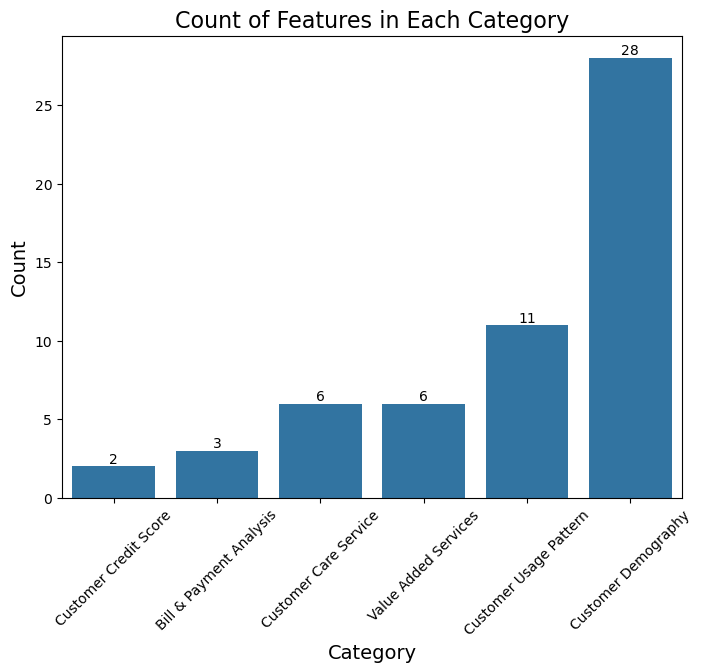

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_data = data_dictionary[
    ~data_dictionary["Category"].isin(["Customer ID", "Response Variable"])
]
_ = sns.countplot(
    x="Category",
    data=plot_data,
    order=plot_data["Category"].value_counts(ascending=True).index,
)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
ax.set_title("Count of Features in Each Category", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Category", fontsize=14)
plt.xticks(rotation=45)

if output_img:
    plt.savefig("./img/m3_fig0.png", bbox_inches="tight")

### Data Summary

In [14]:
discrete_vars, categorical_vars, continuous_vars, binary_vars, id_vars = (
    get_variable_category(X_train)
)

In [15]:
print(f"Number of Discrete Variables: {len(discrete_vars)}")
print(f"Number of Categorical Variables: {len(categorical_vars)}")
print(f"Number of Continuous Variables: {len(continuous_vars)}")
print(f"Number of Binary Variables: {len(binary_vars)}")
print(f"Number of ID Variables: {len(id_vars)}")

Number of Discrete Variables: 7
Number of Categorical Variables: 0
Number of Continuous Variables: 19
Number of Binary Variables: 41
Number of ID Variables: 1


There are no categorical variables because they have all been one-hot encoded.

In [16]:
# Sanity Check
assert len(binary_vars) + len(categorical_vars) + len(discrete_vars) + len(
    id_vars
) + len(continuous_vars) == len(X_train.columns)

#### Discrete Variables

In [17]:
# TODO remove cell
discrete_vars[1:]

['handset_models',
 'retention_calls',
 'retention_offers_accepted',
 'referrals_made_by_subscriber',
 'income_group',
 'credit_rating']

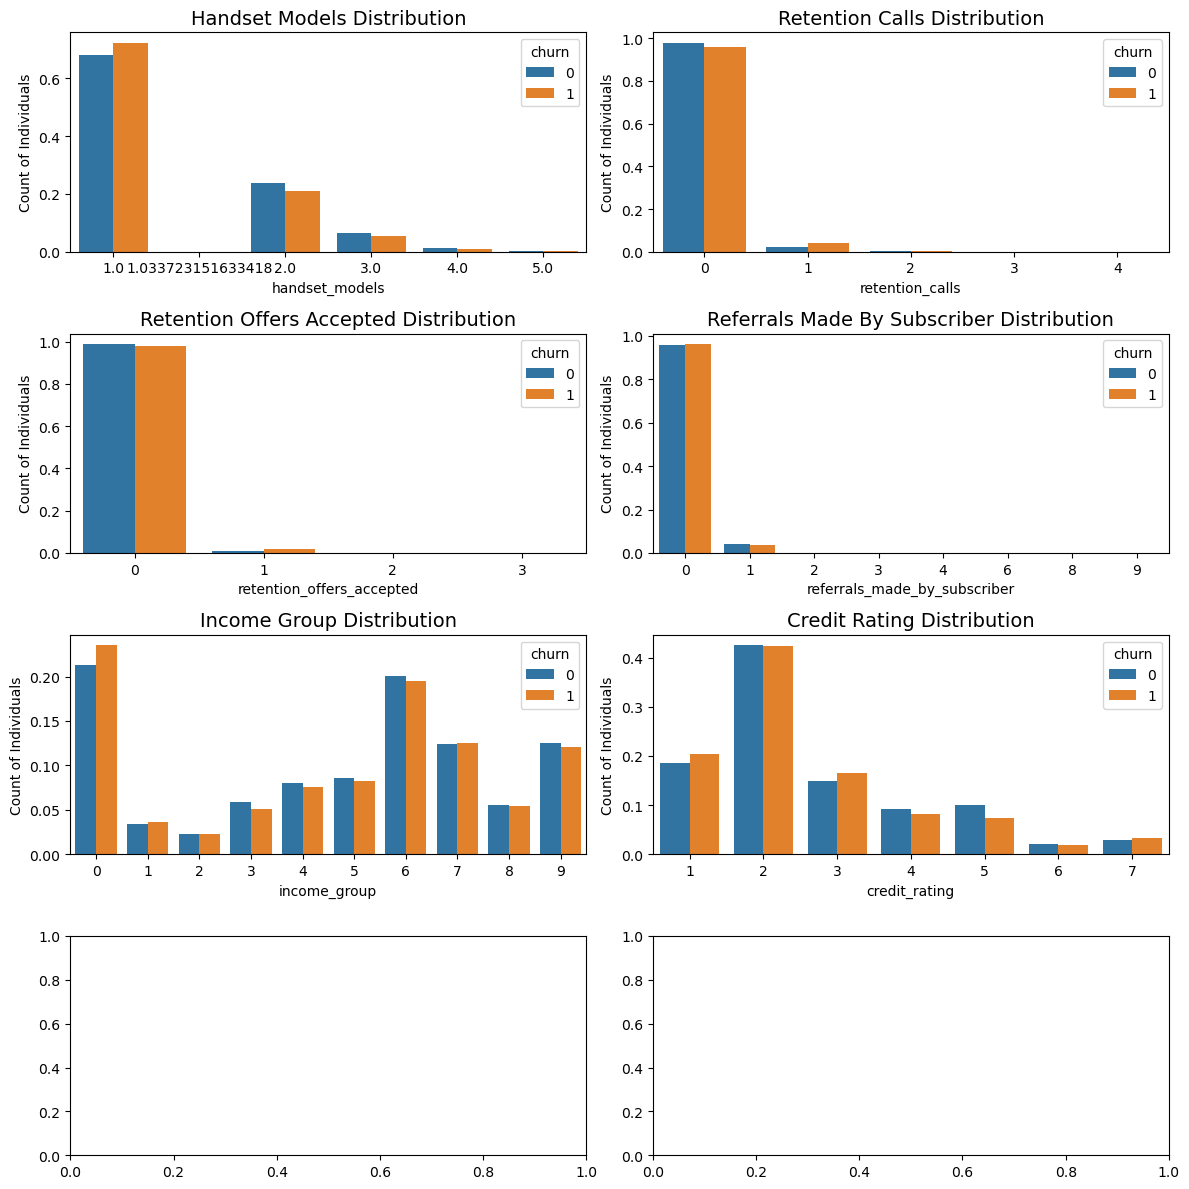

In [18]:
train = pd.concat([X_train, y_train], axis=1)

fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for ax, column in zip(ax.ravel(), discrete_vars[1:]):  # Drop ID
    counts = (
        train[[column, "churn"]]
        .groupby("churn")
        .value_counts(normalize=True)
        .reset_index()
    )
    counts = counts.sort_values(column)

    sns.barplot(x=column, y="proportion", data=counts, ax=ax, hue="churn")
    ax.set_title(f"{split_snake_case(column)} Distribution", fontsize=14)
    ax.set_ylabel("Count of Individuals")
    ax.set_xlabel(column)
    if counts[column].nunique() > 10:
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks[::2])

plt.tight_layout()

In [19]:
if output_img:
    fig.savefig('./img/m3_fig1.png', format='png', dpi=300, bbox_inches='tight')

#### Continuous Variables

In [20]:
# TODO remove cell
continuous_vars

['perc_change_minutes',
 'perc_change_revenues',
 'dropped_calls',
 'unanswered_calls',
 'received_calls',
 'months_in_service',
 'unique_subs',
 'active_subs',
 'current_equipment_days',
 'age_hh1',
 'age_hh2',
 'adjustments_to_credit_rating',
 'handset_price',
 'total_care_issues',
 'overall_revenue',
 'overall_usage',
 'value_added_service_usage',
 'total_calls',
 'total_peak_off_peak_calls']

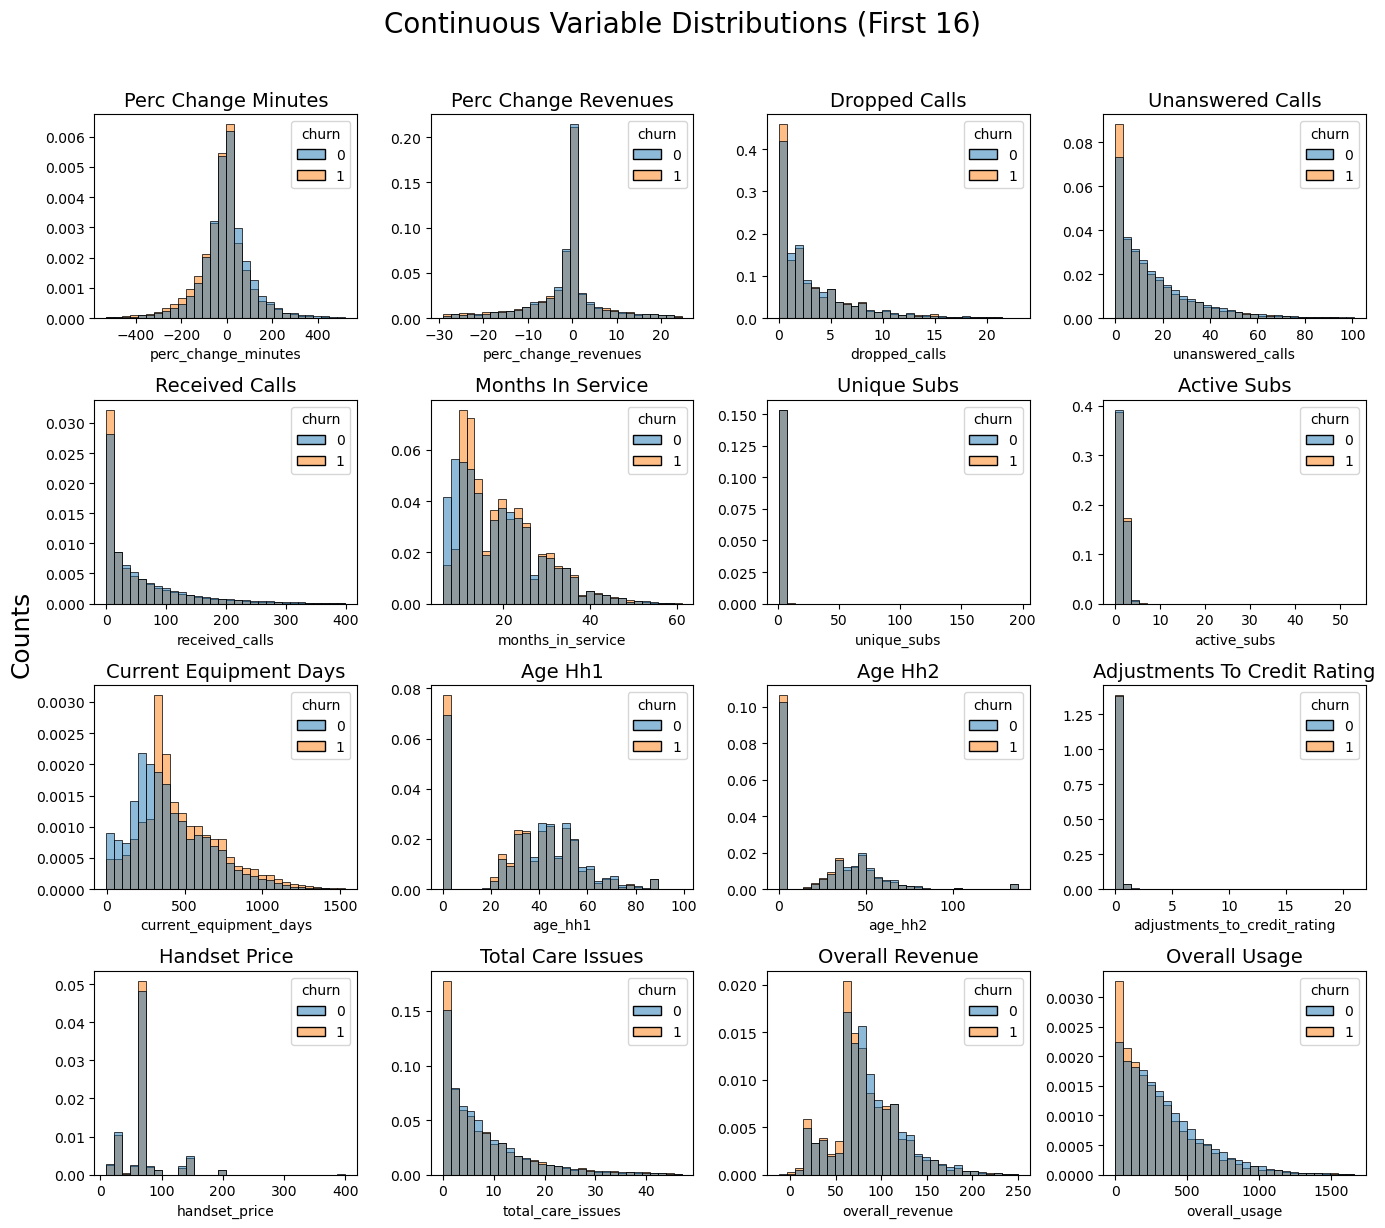

In [21]:
fig, ax = plt.subplots(4, 4, figsize=(14, 12))

for ax, column in zip(ax.ravel(), continuous_vars[:16]):
    sns.histplot(
        x=column,
        data=train[[column, "churn"]],
        bins=30,
        ax=ax,
        hue="churn",
        stat="density",
        common_norm=False,
    )
    ax.set_title(f"{split_snake_case(column)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(column)
fig.supylabel("Counts", fontsize=18)
fig.suptitle("Continuous Variable Distributions (First 16)", fontsize=20, y=1.02)
plt.tight_layout()

In [22]:
if output_img:
    fig.savefig('./img/m3_fig3a.png', format='png', dpi=300, bbox_inches='tight')

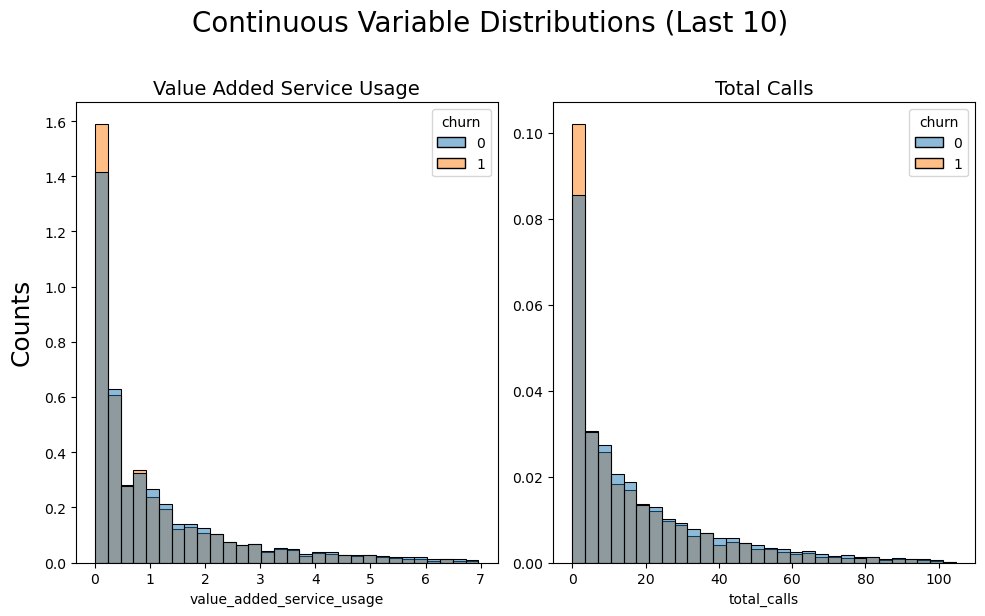

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

axes = ax.ravel()
for ax, column in zip(axes, continuous_vars[16:]):
    sns.histplot(
        x=column, 
        data=train[[column, "churn"]], 
        bins=30, 
        ax=ax, 
        hue="churn", 
        stat="density", 
        common_norm=False
    )
    ax.set_title(f'{split_snake_case(column)}', fontsize=14)
    ax.set_ylabel('')
    ax.set_xlabel(column)
fig.supylabel('Counts', fontsize=18)
fig.suptitle('Continuous Variable Distributions (Last 10)', fontsize=20, y=1.02)

plt.tight_layout()

In [24]:
if output_img:
    fig.savefig('./img/m3_fig3b.png', format='png', dpi=300, bbox_inches='tight')

##### Box Plots

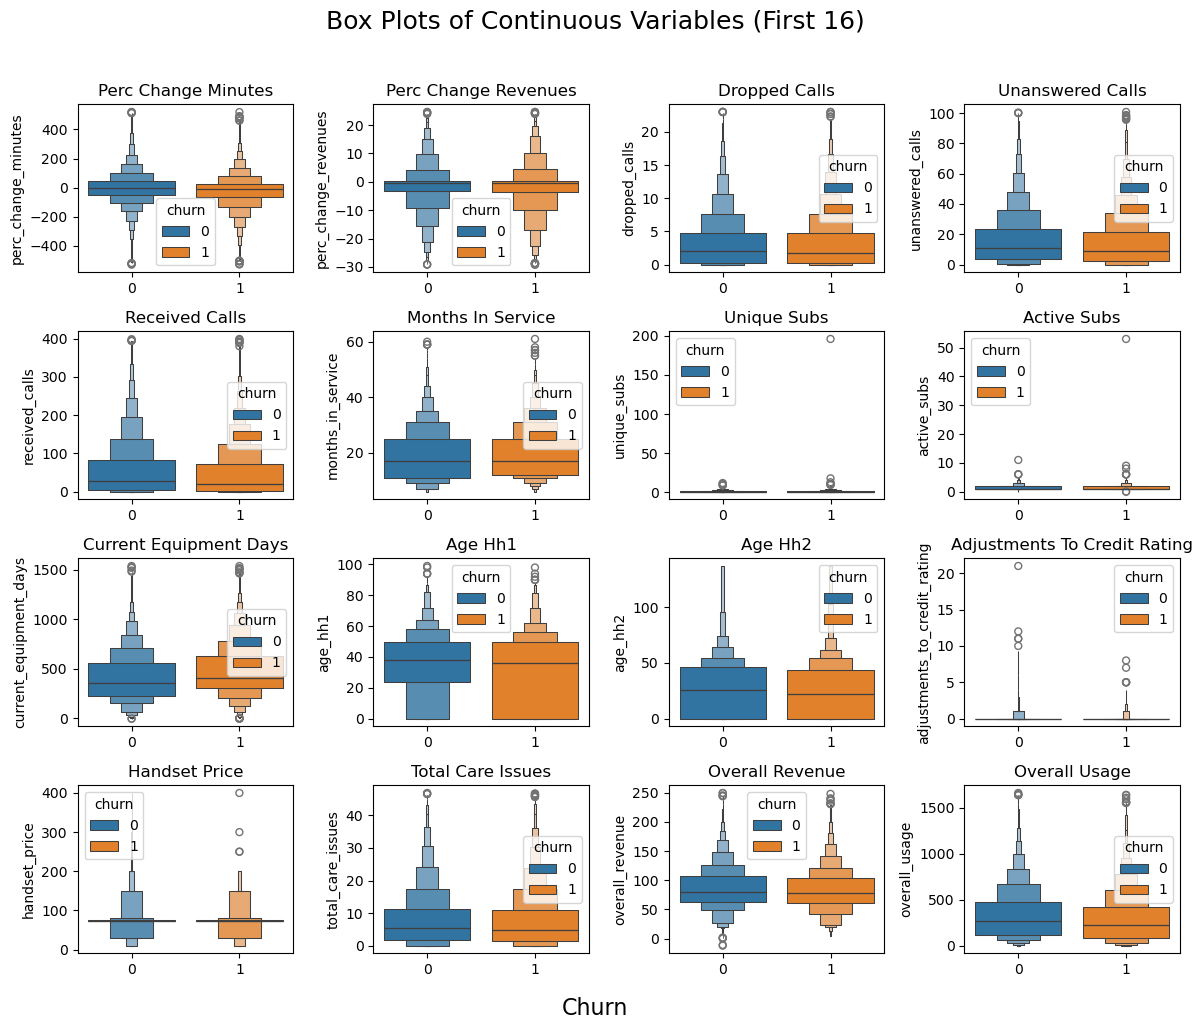

In [25]:
fig, ax = plt.subplots(4, 4, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(), continuous_vars[:16]):

    _=sns.boxenplot(
        x="churn", 
        y=feature, 
        data=train,
        hue='churn', 
        ax=ax
    )
    ax.set_title(split_snake_case(feature).title())
    ax.set_xlabel("")

plt.suptitle("Box Plots of Continuous Variables (First 16)", fontsize = 18, y=1.02)
fig.supxlabel("Churn", fontsize=16)
plt.tight_layout()

In [26]:
if output_img:
    fig.savefig('./img/m3_fig3c.png', format='png', dpi=300, bbox_inches='tight')

#### Binary Variables

In [27]:
# Remove zero-inflated dummies
binary_vars_to_plot = [var for var in binary_vars if var.split("_")[-1] != 'zero']
binary_vars_to_plot

['children_in_hh',
 'handset_refurbished',
 'handset_web_capable',
 'truck_owner',
 'rv_owner',
 'homeownership',
 'buys_via_mail_order',
 'responds_to_mail_offers',
 'opt_out_mailings',
 'non_us_travel',
 'owns_computer',
 'has_credit_card',
 'new_cellphone_user',
 'owns_motorcycle',
 'made_call_to_retention_team',
 'prizm_code_Rural',
 'prizm_code_Suburban',
 'prizm_code_Town',
 'occupation_Crafts',
 'occupation_Homemaker',
 'occupation_Other',
 'occupation_Professional',
 'occupation_Retired',
 'occupation_Self',
 'occupation_Student',
 'marital_status_Unknown',
 'marital_status_Yes']

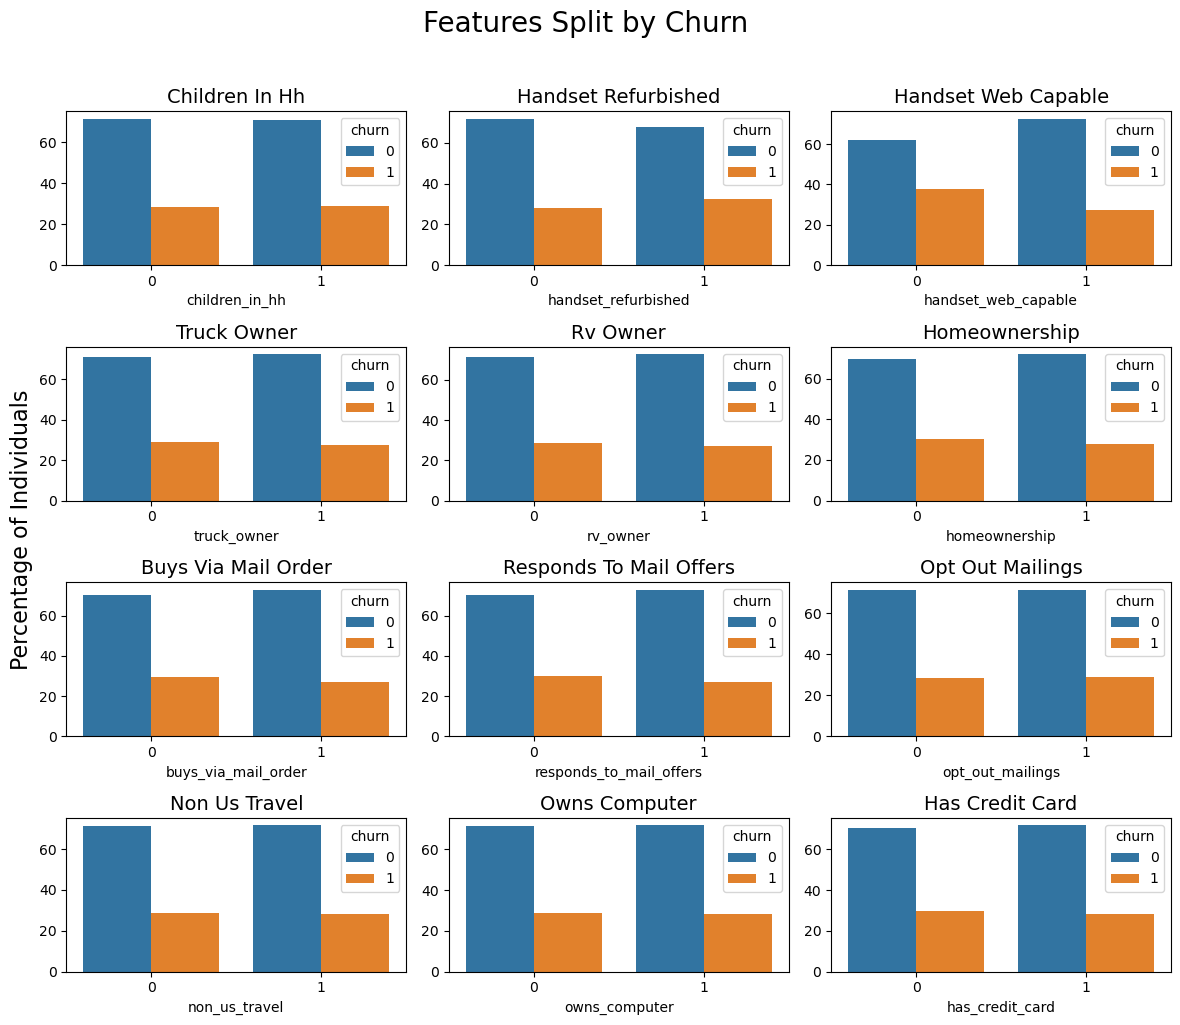

In [28]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[:12]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

In [29]:
if output_img:
    fig.savefig('./img/m3_fig4.png', format='png', dpi=300, bbox_inches='tight')

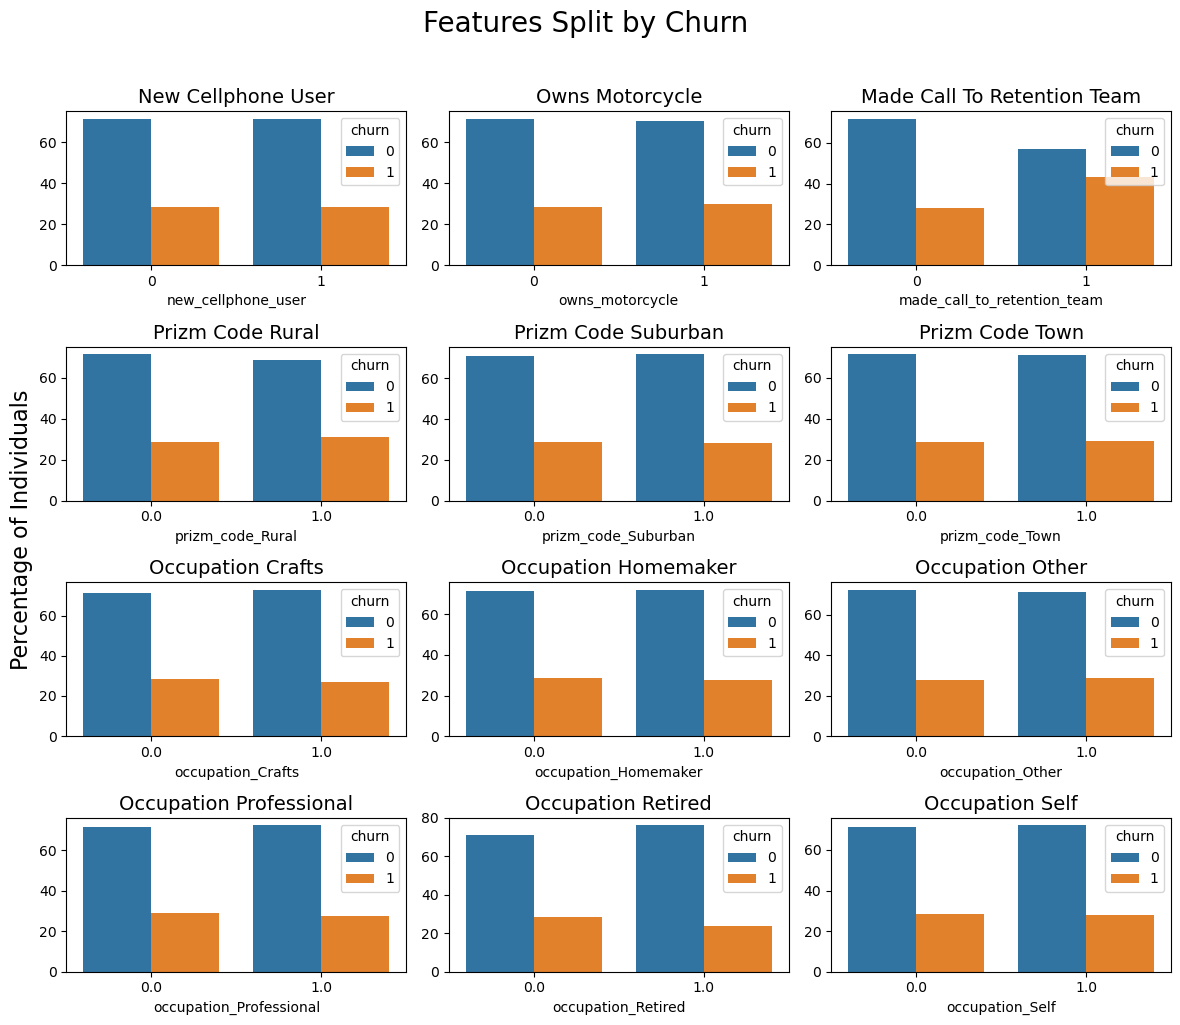

In [30]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[12:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

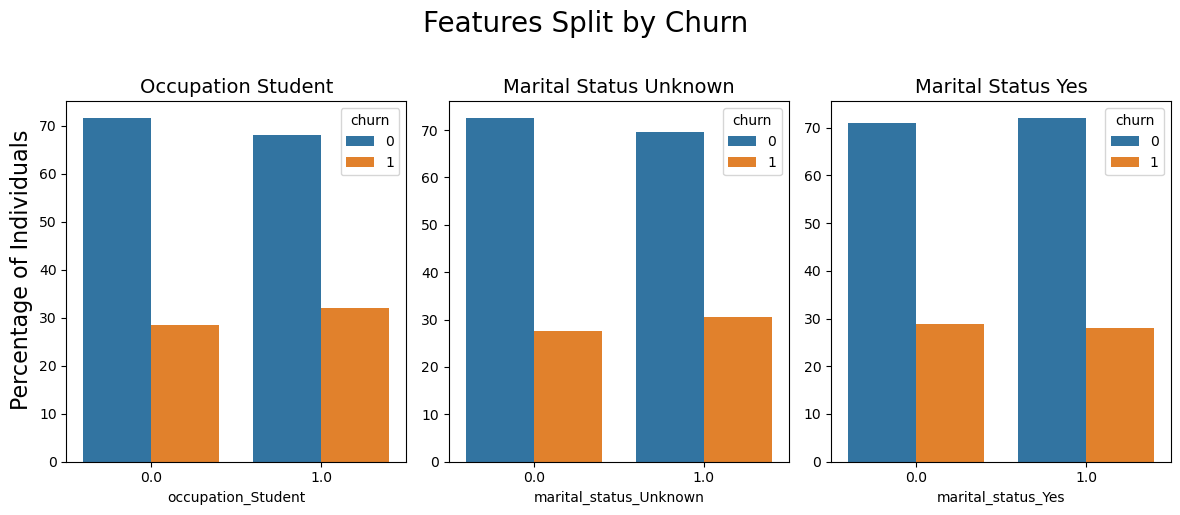

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[24:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

## Exploratory Data Analysis

In [32]:
# TODO check grammar and spelling and make sure the numbers mentioned still match

### Deeper Understanding of the Data

*While basic EDA is important, you should aim to provide a deeper understanding of the data through your analysis. This can be achieved by identifying patterns, trends, class imbalances, and outliers in the data. Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.*

1. Trends: We explored the trend using the only temporal feature "MonthsInService"
   - Initial drop: The churn rate starts around 0.2, drops slightly.
   - Sharp increase: The churn rate increases sharply around the 10 month mark. This could indicate that the users may have some sort of contract that binds them for 10 months.
   - Stablizes: After the spike on the 10th month, churn rate slightly declines and stabilize hovering over 0.2 ~ 0.4 over the next several months.
   - Large fluctuation >50 months: Twards the end, the data shows heavy fluctuation and a spike at the end indicating a potential outlier.
3. Class imbalance: Class imbalance was previously identified and handeled in MS2
4. Outliers:
   - We can identify from the box plot and distribution plots that there are outliers in the dataset. Instead of removing the outliers right now, we'll use different methods such as (1) Cook's distance (if using linear regression) and (2) principal component analysis (PCA) to handle outliers. 
5. Relationship between variables:
   We found strong correlations between features that can lead to multicollinearity. (both shown in the heatmap and pairplots) Later we'll explore methods such as (1) removing one of the correlated features, (2) PCA, (3) feature selection to determine the best method to handle multicollinearity issue.
   - MonthlyRevenue & OverageMinutes: 0.786
   - MonthlyRevenue & MonthlyMinutes: 0.710
   - MonthlyMinutes & ReceivedCalls: 0.828


   However, we didn't find any feature that has direct correlation with Churn. This is interesting as we were expecting at least a weak correlation between some features and churn. It suggests that chrun might depend on more complex interactions between multiple features. 

#### Trends

In [33]:
# TODO title, and axis labels need to be bigger

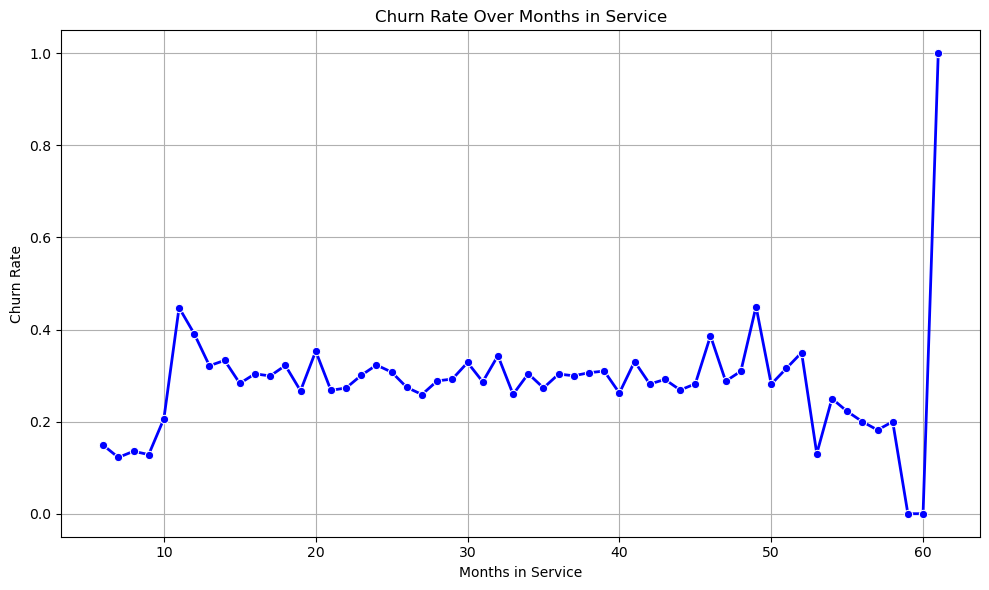

In [34]:
# Identifying the trend using time trended variable: "MonthsInSerivce"

monthly_churn_rate = train.groupby('months_in_service')['churn'].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(x='months_in_service', y='churn', data=monthly_churn_rate, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.title('Churn Rate Over Months in Service')
plt.xlabel('Months in Service')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.tight_layout();

if output_img:
    plt.savefig('./img/m3_fig5.png', format='png', dpi=300, bbox_inches='tight')



In [35]:
# TODO write explanation here

#### Correlation Matrices

In [36]:
batches = list(zip(list(range(0, len(continuous_vars)+1, 6)), list(range(0, len(continuous_vars)+1, 6))[1:]))

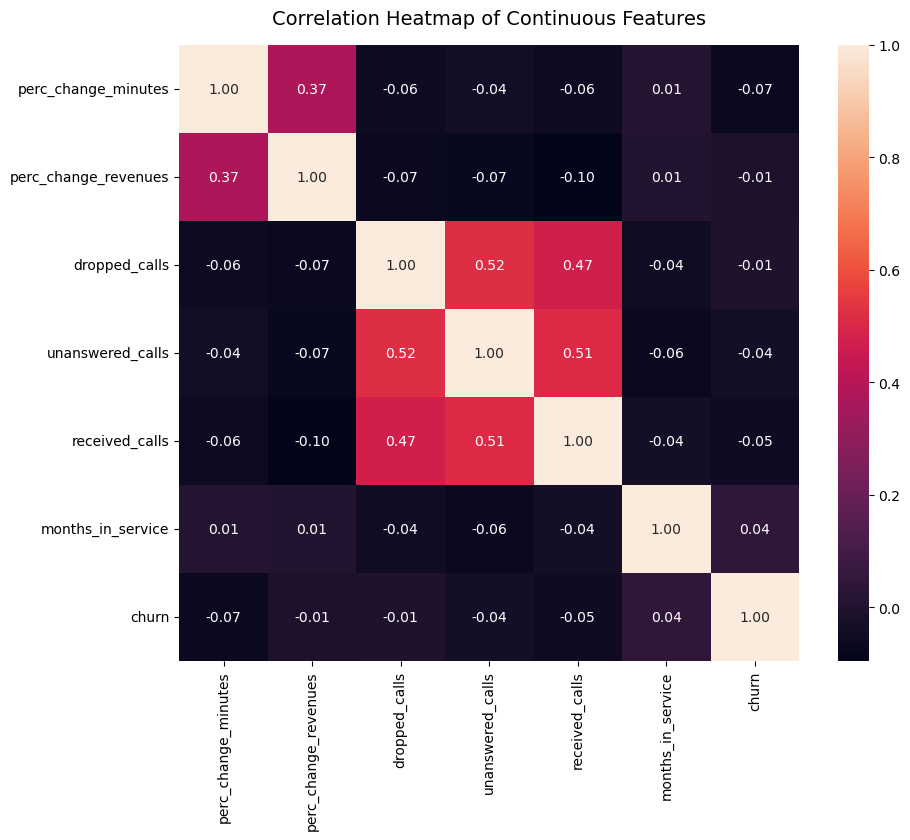

Strong correlations:
                       perc_change_minutes  perc_change_revenues  \
perc_change_minutes                   1.0                   NaN   
perc_change_revenues                  NaN                   1.0   
dropped_calls                         NaN                   NaN   
unanswered_calls                      NaN                   NaN   
received_calls                        NaN                   NaN   
months_in_service                     NaN                   NaN   
churn                                 NaN                   NaN   

                      dropped_calls  unanswered_calls  received_calls  \
perc_change_minutes             NaN               NaN             NaN   
perc_change_revenues            NaN               NaN             NaN   
dropped_calls                   1.0               NaN             NaN   
unanswered_calls                NaN               1.0             NaN   
received_calls                  NaN               NaN             1.0   
mon

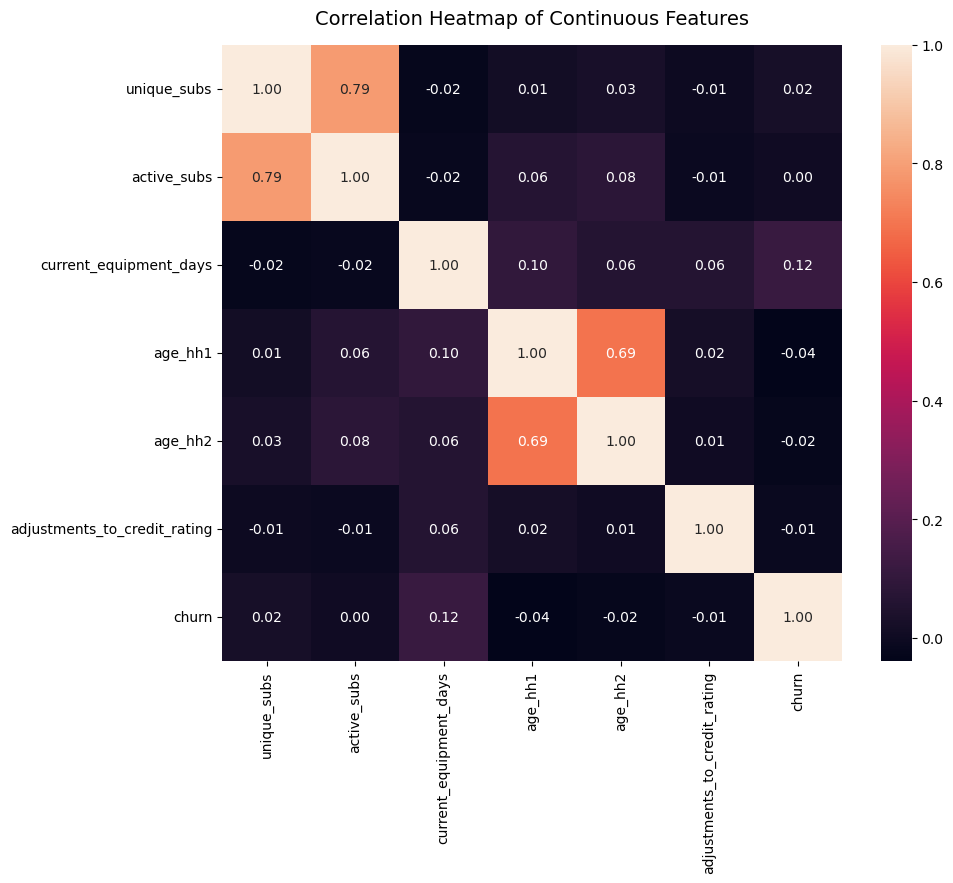

Strong correlations:
                               unique_subs  active_subs  \
unique_subs                      1.000000     0.785652   
active_subs                      0.785652     1.000000   
current_equipment_days                NaN          NaN   
age_hh1                               NaN          NaN   
age_hh2                               NaN          NaN   
adjustments_to_credit_rating          NaN          NaN   
churn                                 NaN          NaN   

                              current_equipment_days   age_hh1   age_hh2  \
unique_subs                                      NaN       NaN       NaN   
active_subs                                      NaN       NaN       NaN   
current_equipment_days                           1.0       NaN       NaN   
age_hh1                                          NaN  1.000000  0.693265   
age_hh2                                          NaN  0.693265  1.000000   
adjustments_to_credit_rating                     NaN     

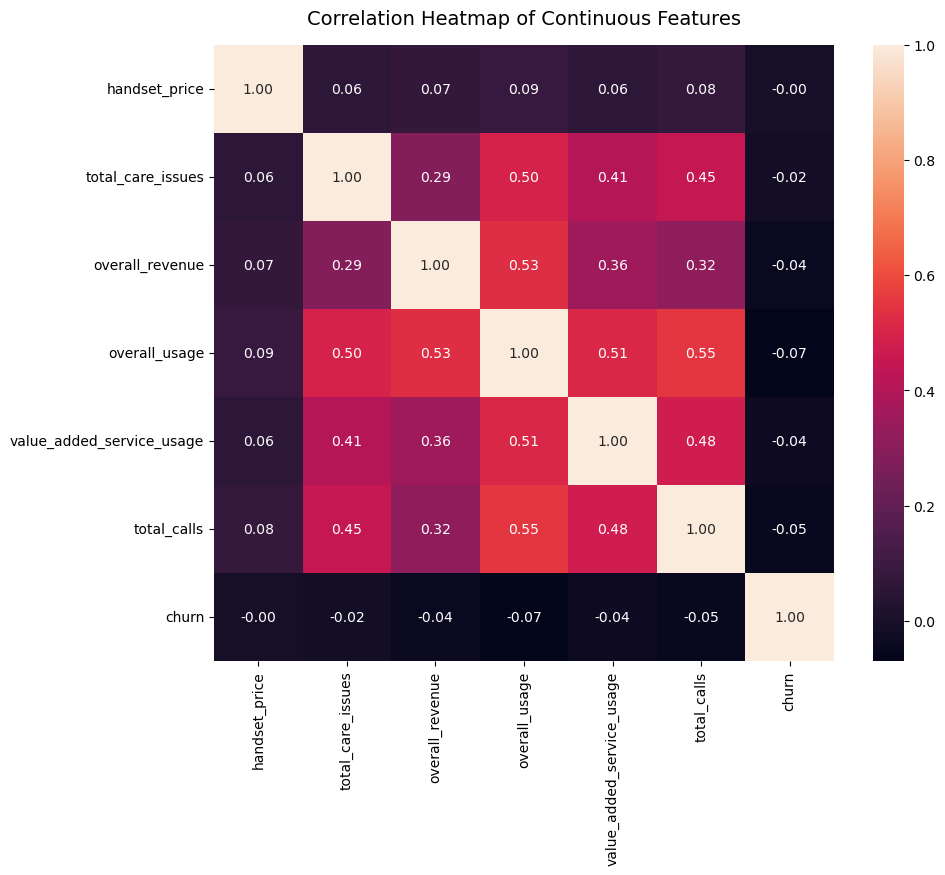

Strong correlations:
                            handset_price  total_care_issues  overall_revenue  \
handset_price                        1.0                NaN              NaN   
total_care_issues                    NaN                1.0              NaN   
overall_revenue                      NaN                NaN              1.0   
overall_usage                        NaN                NaN              NaN   
value_added_service_usage            NaN                NaN              NaN   
total_calls                          NaN                NaN              NaN   
churn                                NaN                NaN              NaN   

                           overall_usage  value_added_service_usage  \
handset_price                        NaN                        NaN   
total_care_issues                    NaN                        NaN   
overall_revenue                      NaN                        NaN   
overall_usage                        1.0             

In [37]:
# Correlation heatmap for continuous variables

for letter, batch in zip(string.ascii_lowercase, batches):
    correlation_matrix = pd.concat([train[continuous_vars[batch[0]:batch[1]]], train['churn']], axis=1).corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10, 8))  
    sns.heatmap(
        correlation_matrix, 
        annot=True,
        fmt=".2f",
        ax=ax
    )
    ax.set_title('Correlation Heatmap of Continuous Features', fontsize=14, y=1.02)
    plt.show();

    # Identify strong correlations (greater than 0.6 or less than -0.6)
    strong_corr = correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)]
    print("Strong correlations:\n", strong_corr)

    if output_img:
        fig.savefig(f'./img/m3_fig6{letter}.png', format='png', dpi=300, bbox_inches='tight')

In [38]:
# Calculate correlations with response
correlations = train[continuous_vars].corrwith(train["churn"])

# Sort correlations in descending order (absolute values for strength)
sorted_correlations = correlations.abs().sort_values(ascending=False)
top5_features = list(sorted_correlations.head(5).index) + ["churn"]
top5_features

['current_equipment_days',
 'overall_usage',
 'perc_change_minutes',
 'total_peak_off_peak_calls',
 'received_calls',
 'churn']

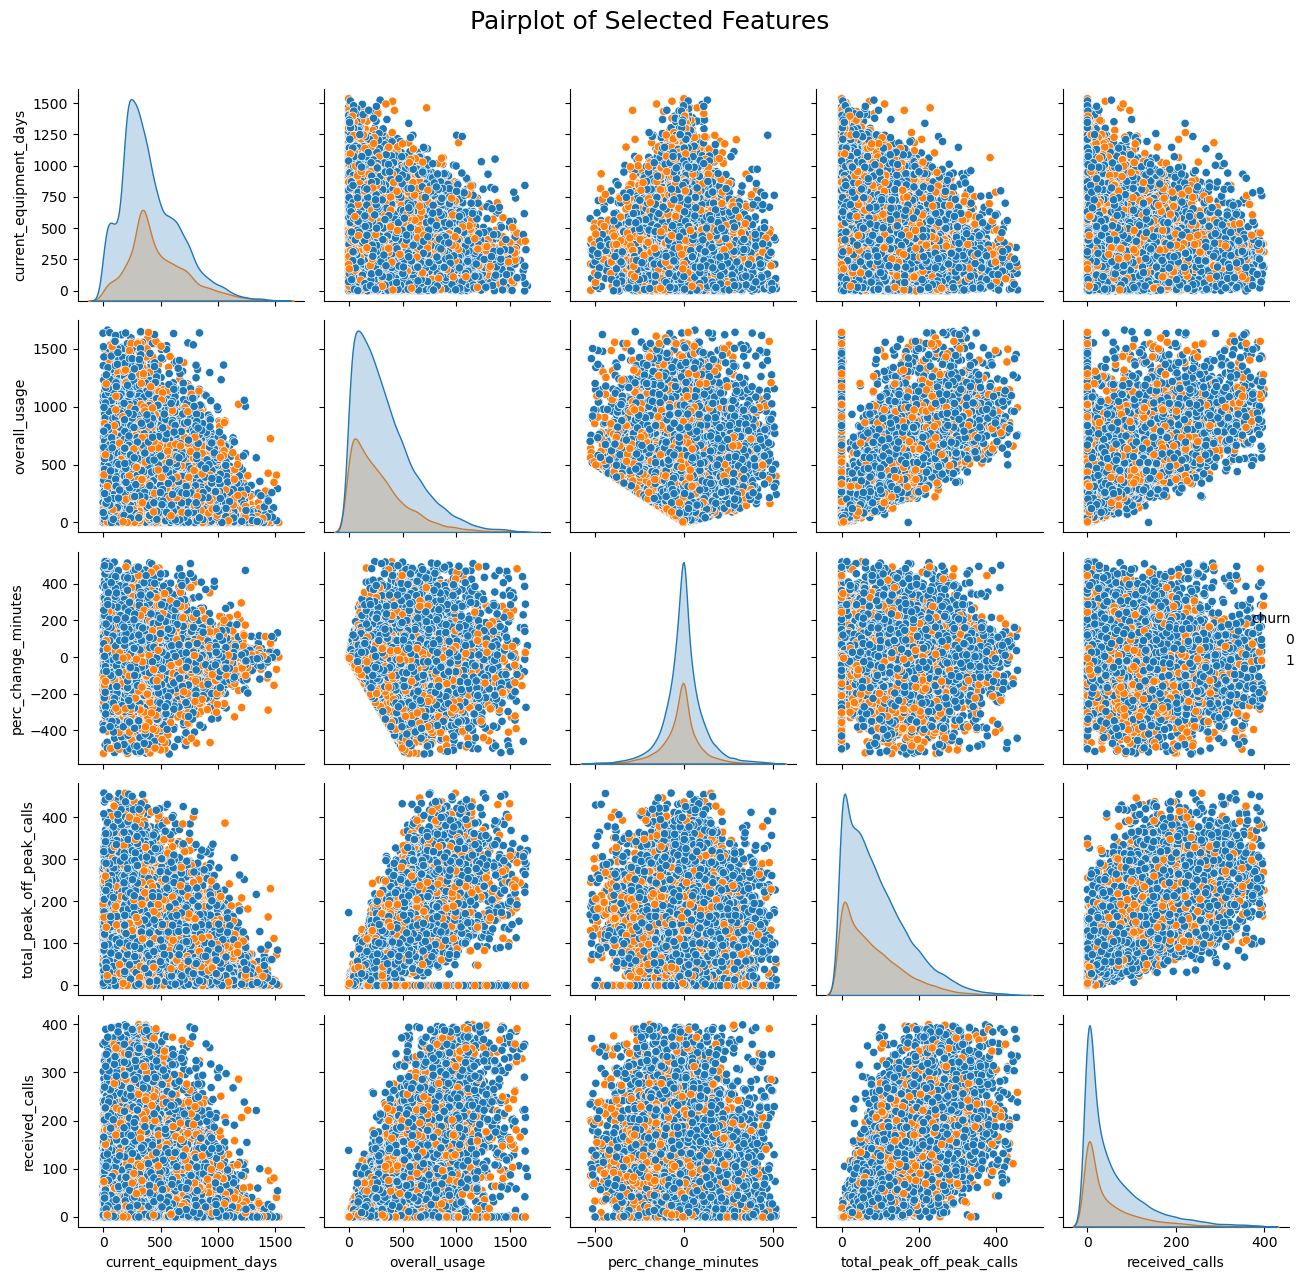

In [39]:
# Pairplot of selected features
pairplot = sns.pairplot(
    train[top5_features], 
    hue='churn'
)
plt.suptitle('Pairplot of Selected Features', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [40]:
if output_img:
    pairplot.savefig(f'./img/m3_fig7.png', format='png', dpi=300, bbox_inches='tight')

In [41]:
# TODO check grammar and spelling and if the numbers mentioned still match

### Meaningful Insights

The EDA report should provide meaningful insights that can be connected back to the problem at hand. These insights should be well-supported by the data and provide actionable recommendations for addressing the problem. You should focus on providing insights that are relevant to the project question and will add value to the final analysis.

### Noteworthy Findings

Summarize the noteworthy findings of their EDA in a clear and concise manner. This can be achieved through the use of visualizations and captions that highlight the most important insights gained through the analysis.

#### Service Quality Impact
- Based on the correlation heatmap and pair plot, we don’t see a strong direct correlation between `DroppedCalls` and `Churn`. This suggests that while service quality could impact churn, `DroppedCalls` alone does not show a significant linear relationship with churn.

#### Financial Patterns
- **Revenue & Charges**: The correlation heatmap shows a strong relationship between `MonthlyRevenue` and `OverageMinutes` (0.79), as well as `MonthlyRevenue` and `MonthlyMinutes` (0.71). 
- **Churn Correlation**: There is a very weak or negligible correlation between financial variables like `MonthlyRevenue`, `TotalRecurringCharge`, and churn, suggesting that churn is likely influenced by more complex interactions of these variables rather than a single factor.

#### Demographic Insights
- **Credit Rating**: Credit rating distribution shows a higher density of churn among customers with a medium (2-High) credit rating.
- **Income Group**: Income Group 6 has the highest representation, while Income Group 0 shows a more varied churn rate.

#### Continuous Variables Analysis
- **Monthly Revenue**: The distribution is heavily right-skewed, with most customers having a monthly revenue below.
- **Monthly Minutes**: Similarly right-skewed, showing that most customers have low usage, but a few consume a large number of minutes.
- **Total Recurring Charge**: Right-skewed distribution suggests that most customers have low recurring charges.

#### Churn Trends Over Time
- **10-Month Spike**: The churn rate chart shows a significant increase around the 10-month mark, possibly indicating a contract or milestone prompting churn.
- **Long-Term Fluctuations**: After stabilizing around 20-40% for most of the service period, churn rate experiences fluctuations after 50 months, with a sharp peak at the end. 

#### Correlation Insights
- **Feature Correlations**: The heatmap shows strong correlations between features like `MonthlyRevenue` & `OverageMinutes` (0.79) and `MonthlyMinutes` & `ReceivedCalls` (0.83), indicating potential multicollinearity, which might need addressing in modeling.
- **No Strong Correlation with Churn**: None of the variables exhibit a strong correlation with churn.


## Research Question

Based on the insights gained through EDA, you should develop a clear project question that will guide your analysis. This question should be well-defined and specific to the problem at hand.

1. **"What variables influence churn, and how can these factors be effectively used to predict customer churn?"**

2. **"How do service usage patterns and financial characteristics, such as monthly revenue and overage charges, impact customer churn rates?"**

3. **"What role do demographic factors (such as income, location, and credit rating) play in predicting customer churn?"**



## Baseline Models

This section focuses on the development and evaluation of two baseline models 1) A naive model that predicts random labels based on the class distribution and 2) a bare bones logistic regression model. These two models serve as the baseline metric to beat going forward. A variety of metrics were employed to comprehensively assess the differences in their predictive performance, such as f1-score and accuracy.

### Naive Model

In [42]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_train, y_train)
y_pred_naive = naive_model.predict(X_train)

print ("Naive Model - Train Data")
print ("="*53)
print (classification_report(y_train, y_pred_naive))

Naive Model - Train Data
              precision    recall  f1-score   support

           0       0.71      0.72      0.72     19408
           1       0.28      0.28      0.28      7759

    accuracy                           0.59     27167
   macro avg       0.50      0.50      0.50     27167
weighted avg       0.59      0.59      0.59     27167



In [43]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_test, y_test)
y_pred_naive = naive_model.predict(X_test)

print ("Naive Model - Test Data")
print ("="*53)
print (classification_report(y_test, y_pred_naive))

Naive Model - Test Data
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      4802
           1       0.29      0.29      0.29      1990

    accuracy                           0.58      6792
   macro avg       0.50      0.50      0.50      6792
weighted avg       0.58      0.58      0.58      6792



### Naive - Logistic Regression

The baseline model was designed as a straightforward Logistic Regression model with the following specifications:
- No regularisation (penalty=None).
- Class weights were set to balanced (class_weight="balanced") to address class imbalance.
- The model was trained on a subset of features (top5_features), selected based on their importance.

In [44]:
if "churn" in top5_features:
    top5_features.remove("churn")

In [45]:
logit_model = LogisticRegression(
    penalty=None, random_state=random_state, class_weight="balanced"
)
logit_model.fit(X_train[top5_features], y_train.values.ravel())

y_pred_logit = logit_model.predict(X_train[top5_features])

print("Logit Model - Train Data")
print ("="*53)
print(classification_report(y_train, y_pred_logit))

Logit Model - Train Data
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     19408
           1       0.35      0.57      0.43      7759

    accuracy                           0.58     27167
   macro avg       0.56      0.57      0.55     27167
weighted avg       0.65      0.58      0.60     27167



In [46]:
y_pred_logit = logit_model.predict(X_test[top5_features])

print("Logit Model - Test Data")
print ("="*53)
print(classification_report(y_test, y_pred_logit))

Logit Model - Test Data
              precision    recall  f1-score   support

           0       0.76      0.58      0.66      4802
           1       0.35      0.56      0.43      1990

    accuracy                           0.57      6792
   macro avg       0.56      0.57      0.54      6792
weighted avg       0.64      0.57      0.59      6792



In [47]:
# TODO recall and precision are hard to memorize
# add in Appendix the formulas, also make sure that numbers match
# if you precision, recall or any other metrics that is not f1 score feel free to delete it

The performance of the baseline logistic regression reveals challenges due to class imbalance, with class 0 (14,663 samples) dominating class 1 (5,857 samples). The model achieves a modest overall accuracy of 0.58, performing better on class 0 (precision: 0.78, recall: 0.57) compared to class 1 (precision: 0.36, recall: 0.59). 

The low f1-score of 0.44 for class 1 highlights difficulties in effectively distinguishing the minority class, likely caused by overlapping feature distributions or inadequate class representation.

The macro average metrics (precision: 0.57, recall: 0.58, F1-score: 0.55) indicate moderate performance across both classes, while the weighted averages slightly favour class 0. To improve, techniques like oversampling (e.g., SMOTE), feature engineering, or hyperparameter tuning should be employed. 

## Models

### Logistic Regression
Learning form the baseline model, the improved model employs advanced techniques to enhance performance:
- L1 Regularisation (penalty="l1") was applied to facilitate feature selection.
- The $C = \frac{1}{\lambda}$ hyperparameter was optimised using cross-validation with LogisticRegressionCV.
- The training dataset was pre-processed to ensure balanced class distributions, improving model robustness.
- The solver `liblinear` was selected because it had no convergence issues.
- PCA was used on binary variables to reduce dimensionality and improve model performance. 90% of the variance was retained.

For the model pipeline, the following steps were implemented:
1. Scaling: we scale before SMOTE to prevent data leakage because if we scale after SMOTE, we're giving information to the scaler about the data generation process of SMOTE. Another way to put it, the mean and standard deviation that is computed from the SMOTE data provides information about how SMOTE was generated and therefore, the model will be able to pick up on that.
2. SMOTE: we oversample the minority class to balance the class distribution.
3. Logistic Regression: we fit the model using the optimised hyperparameters.
4. We use a pipeline to ensure that the SMOTE operates only on the training data and is not applied to the test data

Note that the choice of $k=5$ for k-fold cross validation is arbitrary. It has been shown that there is no unbiased estimator of for the variance of k-fold cross validation (Bengio & Grandvalet, 2004). Furthermore, there have been studies to suggest that $k=10$ is the ideal (Kohavi, n.d.). 

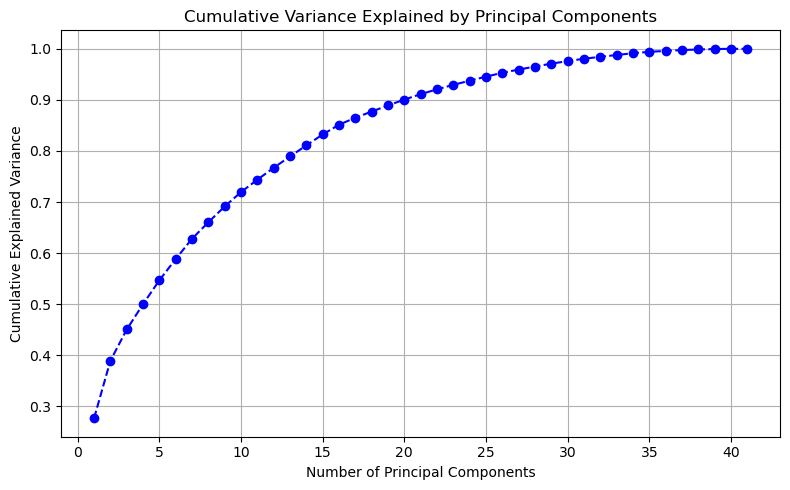

20 components explain 90.0% of the variance.


In [48]:
# Perform PCA
pca = PCA()
pca.fit(X_train[binary_vars])

# Plot the cumulative explained variance, scree plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select components that explain 90% of the variance
cutoff = 0.90
best_n_components = np.argmax(cumulative_variance > cutoff) + 1
print (f"{best_n_components} components explain {cutoff*100}% of the variance.")


In [49]:
# TODO change y axis to percentage 
# Write out math formulas for PCA in the appendix
# Formulas are found in lecture

In [56]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars),
        ('pca', PCA(n_components=best_n_components), binary_vars)
    ], 
    remainder='passthrough', #binary variables passthrough
)

In [ ]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars),
        ('pca', PCA(n_components=best_n_components), binary_vars)
    ], 
    remainder='passthrough', #binary variables passthrough
)

# TODO rename pipeline to something specific to this model
pipeline = Pipeline(
    steps=[
        ('preprocessor', numeric_transformer),
        ("smote", SMOTE(sampling_strategy="auto", random_state=random_state)),
        (
            "clf",
            LogisticRegressionCV(
                Cs=np.logspace(-6, 6, 13),
                cv=5,
                penalty="l1",
                solver="liblinear",
                random_state=random_state,
                max_iter=2000,
                n_jobs=-1,
                class_weight="balanced",
                scoring="accuracy",
            ),
        ),
    ]
)


pipeline.fit(X_train, y_train.values.ravel())

print(
    "Train Accuracy: {:.4f}".format(pipeline.score(X_train, y_train)),
)


Train Accuracy: 0.5773


In [42]:
# Get out the components of the pipelines
X_train_scaled = pipeline.named_steps["preprocessor"].transform(X_train)
X_train_smote, y_train_smote = pipeline.named_steps["smote"].fit_resample(X_train_scaled, y_train)

X_test_scaled = pipeline.named_steps["preprocessor"].transform(X_test)
X_test_smote, _ = pipeline.named_steps["smote"].fit_resample(X_test_scaled, y_test)

best_logit_model = pipeline.named_steps["clf"]

#### Tune Threshold

It is often a strong assumption to make the claim that the threshold of 0.5 is the best threshold for all models. In this case, we will tune the threshold to find the best threshold for our model. We will use the F1 score as the metric to determine the best threshold since the data we are working with is imbalanced.

In [ ]:
# TODO add a quick explanation of the the tradeoff between false positives and false negatives
# when thresholds is changed

In [43]:
best_logit_model_tuned = TunedThresholdClassifierCV(
    estimator = LogisticRegression(
        penalty='l1',
        C=best_logit_model.C_[0],
        solver='liblinear',
        random_state=random_state,
        max_iter=2000,
        class_weight='balanced'
    ),
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())

In [44]:
print ("Optimal Threshold {:.4f}".format(best_logit_model_tuned.best_threshold_))

Optimal Threshold 0.5294


#### Classification Report 

##### Train Set

In [6]:
# TODO up for debate, but delete the training metrics?

In [45]:
# classification report using train data
y_train_pred_logit = best_logit_model_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_logit , zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73     19425
           1       0.38      0.48      0.43      7726

    accuracy                           0.63     27151
   macro avg       0.58      0.59      0.58     27151
weighted avg       0.66      0.63      0.64     27151



##### Test Set

In [8]:
# TODO break this logic into a function and add to utils because it's used a lot

In [46]:
# classification report using test data
y_test_pred_logit = best_logit_model_tuned.predict(X_test.values)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_logit, zero_division=0))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4775
           1       0.39      0.47      0.42      2013

    accuracy                           0.62      6788
   macro avg       0.57      0.58      0.57      6788
weighted avg       0.64      0.62      0.63      6788



/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [7]:
# TODO delete table because it is redundant

The model performs consistently across training (accuracy: 0.63) and test datasets (accuracy: 0.58), demonstrating the model is not overfitting since the two values are relatively close. Comparing the tuned logit to the baseline logit we see a slight improvement across the train and test sets for all metrics.

**Model Performance:**

| Metric         | Baseline Logit | Tuned Logit |
|----------------|----------------|-------------|
| Train Accuracy | 0.58           | 0.63        |
| Test Accuracy  | 0.56           | 0.62        |
| Train F1 Score | 0.55           | 0.58        |
| Test F1 Score  | 0.54           | 0.57        |

#### Confusion Matrix

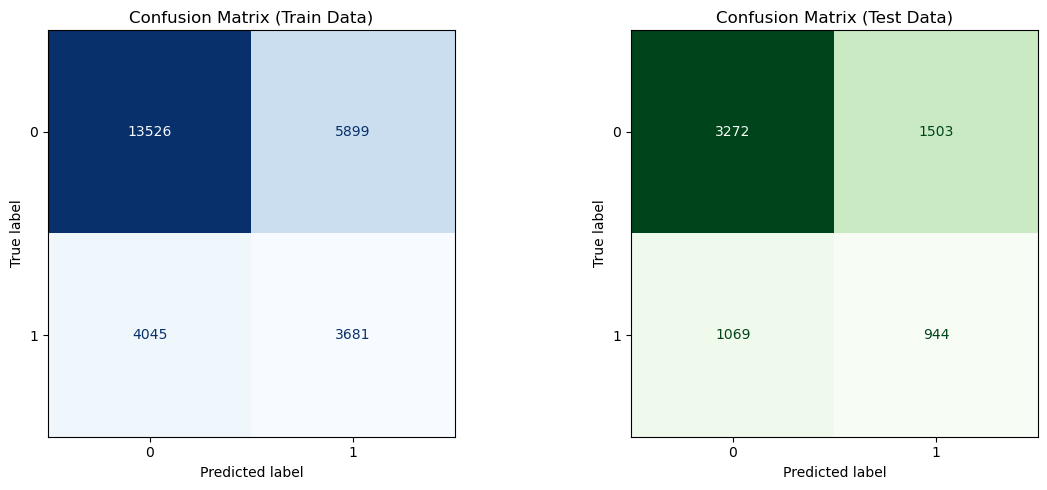

In [47]:
# CM Train data
cm_train = confusion_matrix(y_train, y_train_pred_logit)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=pipeline.classes_)

#  CM Test Data
cm_test = confusion_matrix(y_test, y_test_pred_logit)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=pipeline.classes_)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix (Train Data)')

disp_test.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Confusion Matrix (Test Data)')
plt.tight_layout()

The confusion matrices reveal consistent performance across training and test datasets. 

Overall the model does pretty poorly, with a high number of false negatives and false positives. There doesn't seem to be a bias towards either types of errors. The errors are balanced across Type I and Type II errors. This probably is a result of tuning the threshold to a value other than 0.5.

#### Feature Importance 

In [48]:
# extract features that have coefficient > shreshold
coefficients = best_logit_model.coef_.flatten()
threshold = 0.2
selected_features = [
    feature
    for feature, coef in zip(X_train.columns, coefficients)
    if abs(coef) > threshold
]
selected_coefficients = [coef for coef in coefficients if abs(coef) > threshold]

top_coefficients = pd.DataFrame(
    {"feature": selected_features, "coefficient": selected_coefficients}
).sort_values("coefficient", ascending=True, key=abs)

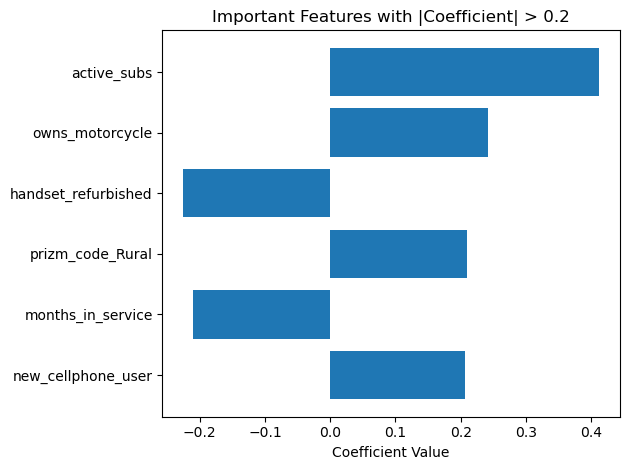

In [49]:
plt.barh(top_coefficients["feature"], top_coefficients["coefficient"])
plt.xlabel('Coefficient Value')
plt.title(f'Important Features with |Coefficient| > {threshold}')
plt.tight_layout()

In [ ]:
# TODO optional, change y labels to Title case using split_snake_case()
# add a dashed line down the middle at 0

In [ ]:
# TODO make sure explanation still matches

The top features based on coefficients are shown above. These are the ones with an absolute magnitude greater than 0.2. Interesting, the dummy for suburban is the most important feature followed by unique subscribers. Months in service makes sense because it might be reflecting the end of the phone contract.

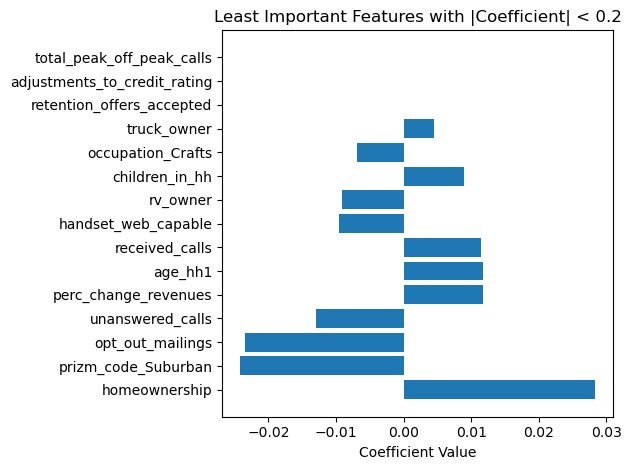

In [50]:
filtered_coefficients = [coef for coef in coefficients if abs(coef) < 0.1]
filtered_features = [
    feature for feature, coef in zip(X_train.columns, coefficients) if abs(coef) < 0.1
]

bottom_coefficients = pd.DataFrame(
    {"feature": filtered_features, "coefficient": filtered_coefficients}
).sort_values("coefficient", ascending=False, key=abs).tail(15)

plt.barh(bottom_coefficients["feature"], bottom_coefficients["coefficient"])
plt.xlabel("Coefficient Value")
plt.title(f"Least Important Features with |Coefficient| < {threshold}")
plt.tight_layout()

In [ ]:
# TODO optional, change y labels to Title case using split_snake_case()
# add a dashed line down the middle at 0

In [ ]:
# TODO make sure explanation still matches

The model identified 7 features with coefficients close to zero (∣coefficient∣<0.01), indicating these features have minimal influence on the model's predictions.  At the top we have value added service usage which was shrunk to zero by the L1 regularisation. RV owner makes sense because that seems unlikely to predict churn. Interestingly retention calls don't seem to have a strong effect on churn.

While these features may not significantly impact the overall performance, they could still provide domain-specific insights. 

#### Model Performance: AUC-ROC Curve


In [51]:
def plot_roc_curves_binary(models, X, y_trues, data_label = 'Train'):
    plt.figure(figsize=(7, 5))
    
    # Dictionary to store AUC for each model
    aucs = {}
    
    for name, model in models.items():
        # Get probability predictions (we want probability of class 1)
        # y_score = cross_val_predict(model, X[name], y_true, method='predict_proba', cv=5)[:, 1]
        y_score = model.predict_proba(X[name])[:, 1]
        y_true = y_trues[name]
        
        # Calculate ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_score)

        roc_auc = roc_auc_score(y_true, y_score)
        
        aucs[name] = roc_auc_score(y_true, y_score)
        
        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {data_label}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return aucs

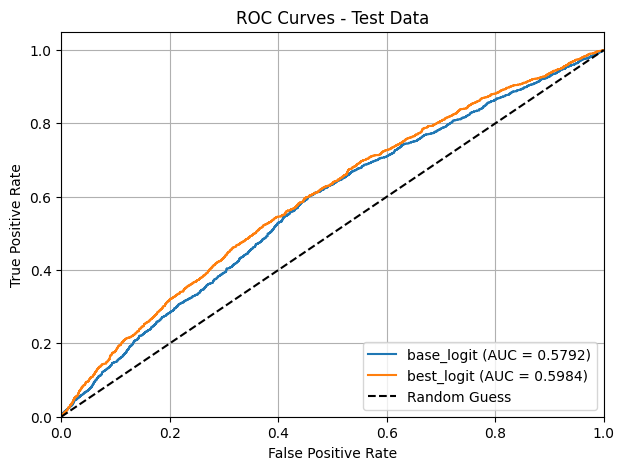

In [52]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

The ROC curve comparison demonstrates a clear improvement in performance between the our tuned logistic model and the Baseline Model. The Baseline Model achieves an AUC of 0.5792 on the test data, indicating weak discriminatory power and limited generalisation capability. In contrast, the Improved Model shows an improvement, with an AUC 0.5984 on the test data, reflecting its stronger ability to distinguish between classes and generalise effectively. 

### Random Forest

In this section, we look to improve predictive performance with a Random Forest model. (TODO give an overview of RF)


Class imbalance is be left as is because trees are robust to class imbalance and prior research on this data set has shown that resampling techniques do not improve model performance (Abdulkadir, 2022). The data will not be scaled either because scaling does not make a difference with tree based models (TODO explain this). The model evaluation metric is the f1-score because it is more reliable than accuracy in the prescence of imbalanced classes.

Our strategy for building the Random Forest model is as follows:

1. The first experiment we run is to determine the optimal number of estimators. Note that random forest models do not overfit, rather the test error plateaus. This is shown by Theorem 1.2 in the Appendix, adapated from "Random Forests" (Breiman, 2001). Regardless, finding the point where the test error plateaus is important in order to save computational resources. We will use the OOB error to determine the number of estimators because 1) it provides a good estimate of the test error and 2) it is computationally efficient. For speed, we will also use large step sizes to get a general sense of where the test error plateaus. Also note that in this experiment we do not prune the trees, as it was recommended not to do so in the original paper (Breiman 2001).

2. The second experiment determines whether the tree is balanced or unbalanced. We will keep the number of estimators fixed and vary the max depth and the max leaf nodes. We will use the OOB error to compare the two models. The model that achieves a greater max accuracy will be chosen. OOB was chosen because it provides a good estimate of the test error and is generated during traiing, removing the need to create validation folds. This stems from the fact that $\frac{1}{e}$ of the data is not used to train each tree due to bootstrapping properties (shown in Appendix Lemma 2).

**Mathematical Aside**

Recall that the average of $B$ i.i.d random variables with variance $\sigma^2$ has variance $\frac{\sigma^2}{B}$. If the variables are identically distributed but not independent with correlation $\rho$, the variance of the average is given by

$$
Var(X) = \rho \sigma^2 + \frac{1-\rho}{B} \sigma^2
$$

, where $X = \sum_{i=1}^B X_i$. When you have decorrelated trees, the first term vanishes. This formula underpins the motivation for using Random Forest.

#### Experiment 1 - Finding Number of Estimators

In [53]:
#Find optimal depth of trees
from sklearn.model_selection import cross_validate

res_df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']

# Set large because we want to see where the overfitting happens
initial_n = 100
end_n = 800
step = 50

# Find max leaf nodes
results = []
for cur_criterion in criterion:      
    for n_estimator in range(initial_n, end_n, step):
        
        rf = RandomForestClassifier(
            n_estimators=n_estimator, 
            criterion=cur_criterion, 
            min_samples_split=2,
            min_samples_leaf=1,
            max_leaf_nodes=None, 
            max_depth=None,
            random_state=random_state, 
            class_weight='balanced_subsample',
            oob_score=True
        ).fit(X_train, y_train.values.ravel())
                
        cur_results = {
            'criterion': cur_criterion,
            'n_estimators': n_estimator,
            # 'all_cv': scores['test_score'],
            'mean_cv': rf.oob_score_
        }
        results.append(cur_results)
res_df = pd.DataFrame(results)

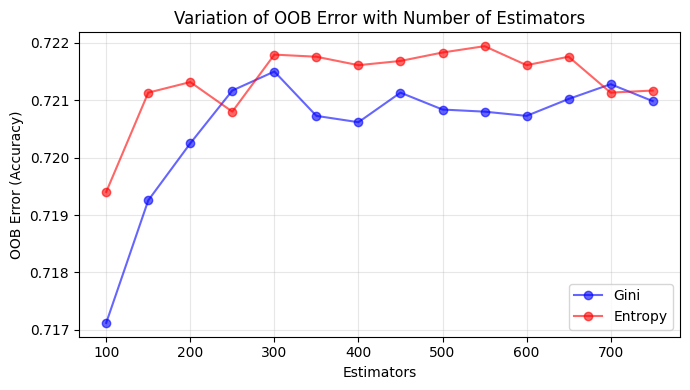

In [54]:
plt.figure(figsize=(7, 4))

#Gini Plot
plt.plot(
    res_df[res_df.criterion == 'gini'].n_estimators,
    res_df[res_df.criterion == 'gini'].mean_cv, 
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Gini'
)
# Entropy Plot
plt.plot(
    res_df[res_df.criterion == 'entropy'].n_estimators,
    res_df[res_df.criterion == 'entropy'].mean_cv, 
    'r-', 
    marker='o', 
    alpha = 0.6, 
    label='Entropy'
)

plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Estimators")
plt.title('Variation of OOB Error with Number of Estimators')
plt.legend()
plt.grid(alpha = 0.3)

plt.tight_layout()
plt.show()

From the plot above we see that the optimal number of estimators is around 300-400 since the OOB error plateaus. It is interesting that the OOB error for entropy increases and doesn't show a plateau quite yet but for the sake of computation time we will choose 400 estimators. An added bonus of this result shows that entropy performs slightly better than Gini. Recall that entropy as a measure is more harsh than Gini, meaning it is more sensitive to changes near the decision boundary. This means entropy can lead to finer splits and potentially better performance.

Experiment 1 Results
- Entropy
- 400 estimators

#### Experiment 2 - Balanced vs Unbalanced Tree

In [55]:
initial_depth = 10
end_depth = 100
step = 10

exp2_results = []

for depth in range(initial_depth, end_depth, step):
        
    rf = RandomForestClassifier(
        n_estimators=400, 
        criterion="entropy", 
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=depth,
        random_state=random_state, 
        class_weight='balanced_subsample',
        oob_score=True
    ).fit(X_train, y_train.values.ravel())
            
    cur_results = {
        'max_depth': depth,
        'mean_cv': rf.oob_score_
    }
    print (cur_results)
    exp2_results.append(cur_results)

{'max_depth': 10, 'mean_cv': 0.5935509993742408}
{'max_depth': 20, 'mean_cv': 0.7122243898847866}
{'max_depth': 30, 'mean_cv': 0.7210586373173336}
{'max_depth': 40, 'mean_cv': 0.7216475871461699}
{'max_depth': 50, 'mean_cv': 0.7218316339676814}
{'max_depth': 60, 'mean_cv': 0.7216107777818677}
{'max_depth': 70, 'mean_cv': 0.7216107777818677}
{'max_depth': 80, 'mean_cv': 0.7216107777818677}
{'max_depth': 90, 'mean_cv': 0.7216107777818677}


In [56]:
initial_nodes = 3000
end_nodes = 5500
step = 500

exp2_results_unbalanced = []

for max_node in range(initial_nodes, end_nodes, step):
        
    rf = RandomForestClassifier(
        n_estimators=400, 
        criterion="entropy", 
        min_samples_split=2,
        min_samples_leaf=1,
        max_leaf_nodes=max_node,
        random_state=random_state, 
        class_weight='balanced_subsample',
        oob_score=True
    ).fit(X_train, y_train.values.ravel())
            
    cur_results = {
        'max_leaf_nodes': max_node,
        'mean_cv': rf.oob_score_
    }
    print (cur_results)
    exp2_results_unbalanced.append(cur_results)

{'max_leaf_nodes': 3000, 'mean_cv': 0.7175985570729193}
{'max_leaf_nodes': 3500, 'mean_cv': 0.719402215923731}
{'max_leaf_nodes': 4000, 'mean_cv': 0.7206169249457062}
{'max_leaf_nodes': 4500, 'mean_cv': 0.7216475871461699}
{'max_leaf_nodes': 5000, 'mean_cv': 0.7216475871461699}


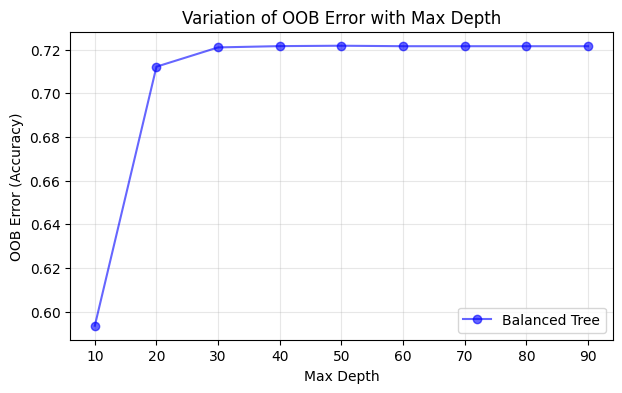

In [57]:
plt.figure(figsize=(7, 4))

exp2_results = pd.DataFrame(exp2_results)

# Balanced Tree
plt.plot(
    exp2_results.max_depth,
    exp2_results.mean_cv,
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Balanced Tree'
)
plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Max Depth")
plt.title('Variation of OOB Error with Max Depth')
plt.legend()
plt.grid(alpha = 0.3)

plt.show()

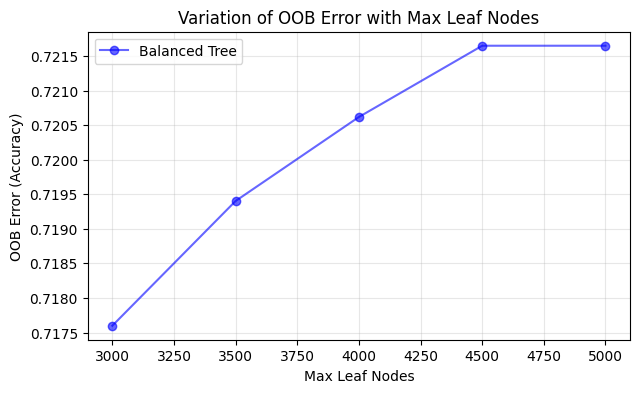

In [58]:
plt.figure(figsize=(7, 4))

exp2_results_unbalanced = pd.DataFrame(exp2_results_unbalanced)

# Unbalanced Tree
plt.plot(
    exp2_results_unbalanced.max_leaf_nodes,
    exp2_results_unbalanced.mean_cv,
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Balanced Tree'
)
plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Max Leaf Nodes")
plt.title('Variation of OOB Error with Max Leaf Nodes')
plt.legend()
plt.grid(alpha = 0.3)

plt.show()

We see that a balanced tree tops out a 0.722 OOB accuracy while the unbalanced tree has a peak of 0.722 as well. The max leaf nodes at this point was 4500. Admittingly this experiment was crude however it showed us that it doesn't matter much if the tree is balanced or unbalanced. Regardless we'll use the unbalanced tree going forward.

Experiment 2 Results
- Tie, but we'll use unbalanced tree

#### Hyperparameter Tuning

We will reserve tuning for MS5 but for now we will sketch out the plan.
1. We will use random search to find areas in the hyperparameter space that are promising. Once we identified these areas we will sort based on performance and take the range of hyperparameters that performed the best. The reason why is because the theoretical dimensions of the hyperparameter space is infinite. All hypterparameters $h \in \mathbb{R}^+$ except for `min_impurity_decrease`, which is between [0, 1]. However it has been shown that there are an infinite number of rationals between two real numbers. So again the space is infinite. This is why we use random search to find promising areas.  
2. We will then use BayesSearchCV to find the optimal hyperparameters within the range we identified in step 1. This is a more efficient method than random search because it uses the information from the previous iterations to inform the next iteration.
3. We will then tune the threshold to find the optimal threshold for the model.

In [59]:
rf_model = RandomForestClassifier(
    n_estimators=400, 
    criterion="entropy", 
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=4000,
    random_state=random_state, 
    class_weight='balanced_subsample',
)

In [60]:
rf_tuned = TunedThresholdClassifierCV(
    estimator = rf_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())

In [61]:
print ("Best Threshold: {:.4f}".format(rf_tuned.best_threshold_))

Best Threshold: 0.3438


#### Model Results

In [62]:
# classification report using train data
y_train_pred_rf = rf_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_rf, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19408
           1       0.98      1.00      0.99      7759

    accuracy                           0.99     27167
   macro avg       0.99      1.00      0.99     27167
weighted avg       0.99      0.99      0.99     27167



In [ ]:
# classification report using test data
y_test_pred_rf = rf_tuned.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      4802
           1       0.41      0.53      0.46      1990

    accuracy                           0.64      6792
   macro avg       0.60      0.61      0.60      6792
weighted avg       0.67      0.64      0.65      6792



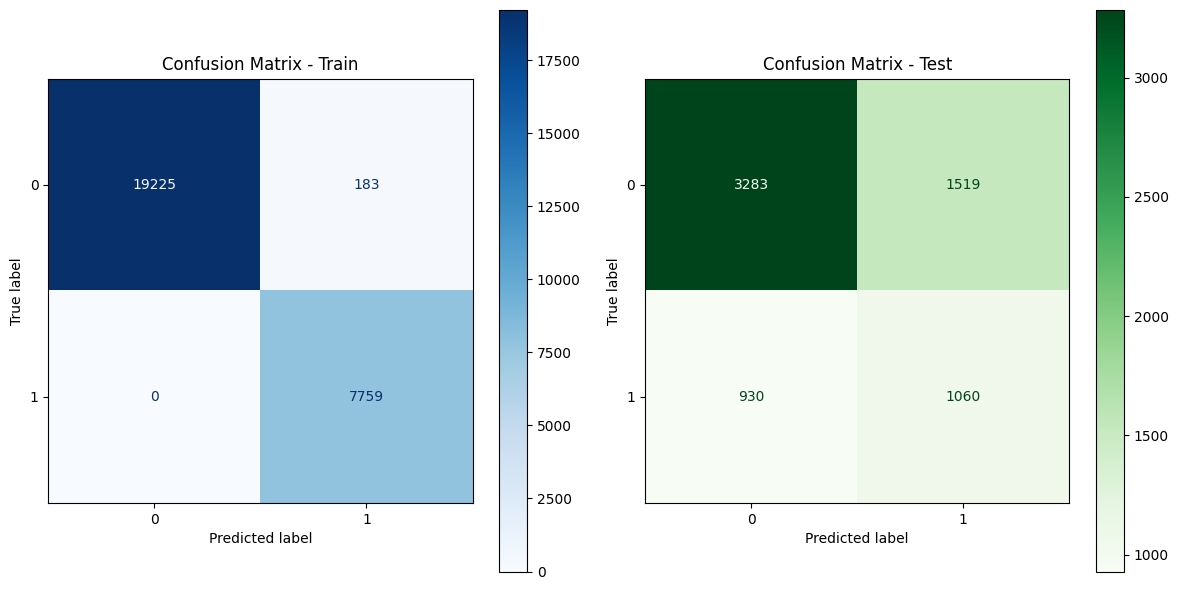

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

ConfusionMatrixDisplay.from_predictions(
    y_train,
    rf_tuned.predict(X_train),
    cmap=plt.cm.Blues,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix - Train')

ConfusionMatrixDisplay.from_predictions(
    y_test,
    rf_tuned.predict(X_test),
    cmap=plt.cm.Greens,
    ax=axes[1] 
)
axes[1].set_title('Confusion Matrix - Test')

plt.tight_layout()


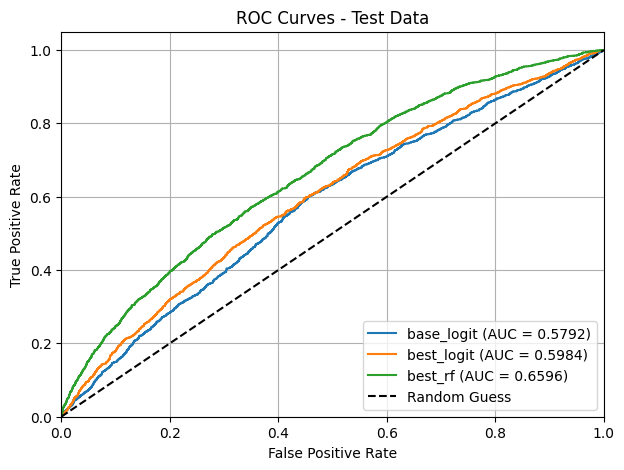

In [65]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
    'best_rf': rf_tuned.estimator_
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
    'best_rf': X_test,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
    'best_rf': y_test,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

Following the paper's methodology we improve on the random forest model by allowing the trees to grow deep and relying on the ensemble to reduce variance. We also use entropy as the criterion because it is more sensitive to changes near the decision boundary. This means that entropy can lead to finer splits and potentially better performance. The AUC has improved and the test accuracy and f1 score have also improved. We include the AUC-ROC curve because it has been shown that is a better metric than accuracy (Ling et al., 2003).

#### Feature Importance

##### MDI

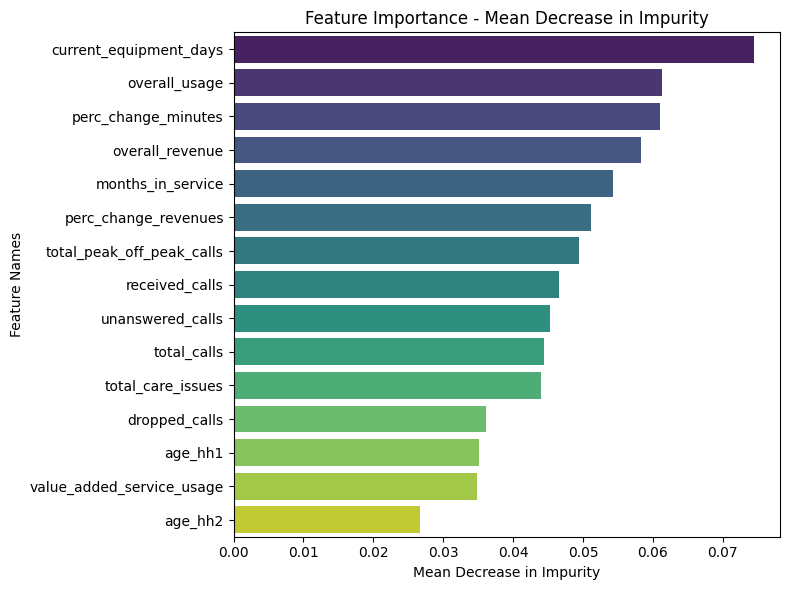

In [66]:
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": rf_tuned.estimator_.feature_importances_}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=feature_importance.head(15), 
    palette="viridis",
    hue="Feature"
)
plt.title("Feature Importance - Mean Decrease in Impurity")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature Names")
plt.tight_layout()

##### Permutation Importance

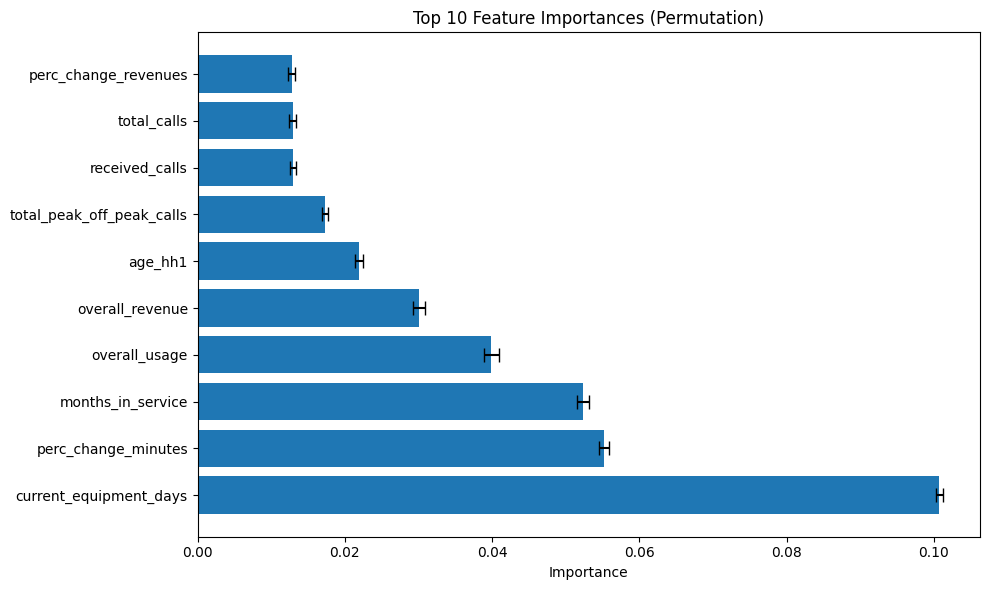

In [67]:
# Might delete takes too long
# Permutation Importance (more robust)
result = permutation_importance(
    rf_tuned.estimator_, 
    X_train, 
    y_train,
    n_repeats=5,
    random_state=random_state
)

# Create dataframe of permutation importances
perm_imp = pd.DataFrame({
    # 'feature': X_train_dt.columns,
    'feature': X_train.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

# Plot top 10 features with error bars
plt.figure(figsize=(10, 6))
top_10 = perm_imp.head(10)
plt.barh(
    range(len(top_10)), 
    top_10['importance_mean'],
    xerr=top_10['importance_std'], 
    capsize=5
)
plt.yticks(range(len(top_10)), top_10['feature'])
plt.title('Top 10 Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

**MDI: Mean Decrease Impurity**

MDI ranks variables by their contribution to reducing impurity in decision trees. The metric essentially finds every split that uses a given feature $q$ and computes the decrease in impurity from parent node to child nodes. The decreases are summed up over the tree and averaged over all trees in the forest to yield the MDI. Formulas can be found in the Appendix.

The top 3 features based on MDI are:
- current_equipment_days
- overall_usage
- perc_change_minutes

**Permutation Importance** 

The permutation importance of a feature is the drop in model accuracy when a given feature is shuffled. For $K$ shuffles, the value is

$$
s - \frac{1}{K} \sum_{i=1}^K s_{k}
$$

where $s$ is the original score and $s_{k}$ is the score for the $k$-th shuffle.

The top 3 features based on permutation importance are:
- current_equipment_days
- perc_change_minutes
- months_in_service

Notice that the features in permutation importance and MDI don't necessarily agree, although in our case it comes quite close. The reason is that MDI focuses on the impurity reduction of a single split. This means that MDI may miss the interaction effects that a given feature has with other features. Permutation importance on the other hand captures these interaction effects because it shuffles the feature and any interaction effects that includes the feature will be lost as well.


...

### Boosted Models

For our final prediction model, we opt for a boosting algorithm. Boosting differs from bagging in that or any parametric model because the search is in the function space and not the parameter space. The objective is to find the optimal function $\hat{f}: X \rightarrow y$. The optimal mapping is found by minimizing the loss function; MSE for regression and log-loss for classification. Focusing on classification, each subsequent tree predicts the residuals which is defined as $r_i = y_i - \hat{p}_i$, where $\hat{p}_i$ is the predicted probability of the majority class.


The candidate models will be AdaBoost and Gradient Boosting (classification trees). We'll use the same pipeline as before. All results are displayed at the end of the section.

**Overview**

Boosting differs from bagging in that it builds trees sequentially. The first tree, in the case of gradient boosting, is a stump that predicts the probability of the majority class. The subsequent trees are trained recursively on the residuals of the previous tree. As a result, we do not get the benefit of averaging over many uncorrelated samples and trees, making overfitting a concern. The objective of first experiment is then simple, to find the number of trees for which the boosted model will overfit. 

From there we conduct hyperparameter tuning. As mention in the prior section, the space of possible hyperparameters is theoretically infinite. Therfore we will do the search in stages:

1) Random search to find promising areas in the hyperparameter space
2) Using the range of the top 5 hyperparameters from step 1, we will construct another, smaller set of hyperparameters to search over
3) We will then use GridSearchCV to find the optimal hyperparameters within the range we identified in step 2. This restricts the search space to a smaller area and allows us to find the optimal hyperparameters.
4) We tune the threshold by using f1-score

### AdaBoost

#### Random Search

In [68]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

ada_pipeline = Pipeline(steps=[
    ('preprocessor',ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), nonbinary_vars)
        ],
        remainder='passthrough'
    )),
    ('classifier', AdaBoostClassifier(
        estimator = DecisionTreeClassifier(max_depth=1),
        algorithm="SAMME"
    ))
])

param_grid = {
    'classifier__n_estimators': np.arange(50, 800, 50),
    'classifier__learning_rate': np.logspace(-4, 0, 8),
    'classifier__estimator__max_depth': np.arange(1, 10, 1),
}

rsearch = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1
).fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [69]:
top_5_results = rsearch.cv_results_['mean_test_score']
top_5_indices = np.argsort(top_5_results)[-5:][::-1]
top_5_params = rsearch.cv_results_['params']
top_5_scores = top_5_results[top_5_indices]

In [70]:
ada_top_5 = pd.DataFrame(top_5_params).iloc[top_5_indices]
ada_top_5['score'] = top_5_scores
ada_top_3 = ada_top_5.head(3)
ada_top_3

classifier__n_estimators  classifier__learning_rate  \
9                       300                        1.0   
2                       150                        1.0   
7                       650                        1.0   

   classifier__estimator__max_depth     score  
9                                 7  0.559047  
2                                 5  0.540690  
7                                 2  0.510067

Note that the learning rate is an additional dampening multiplier on the contribution of each tree. Adaboost on its own has a $\lambda$ that is found by minimizing the exponential loss. The learning rate in sklearn multiplies this. Interestingly for us it seems that the optimal lambda is the best and no further dampening factor is needed.

#### Grid Search

In [71]:
restricted_est = np.arange(
    ada_top_3["classifier__n_estimators"].min(),
    ada_top_3["classifier__n_estimators"].max() + 1,
    50,
)
restricted_depth = np.arange(
    ada_top_3["classifier__estimator__max_depth"].min(),
    ada_top_3["classifier__estimator__max_depth"].max() + 1,
    1,
)

In [72]:
ada_boost_param_grid = {
    'classifier__n_estimators': restricted_est,
    'classifier__learning_rate': [1],
    'classifier__estimator__max_depth': restricted_depth,
}

In [73]:
gsearch = GridSearchCV(
    ada_pipeline,
    param_grid=ada_boost_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=1
).fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 66 candidates, totalling 330 fits


In [74]:
gsearch.best_params_

{'classifier__estimator__max_depth': np.int64(7),
 'classifier__learning_rate': 1,
 'classifier__n_estimators': np.int64(250)}

In [75]:
gsearch.score(X_test, y_test)

np.float64(0.5537456639068864)

#### Tune Threshold

In [76]:
best_adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=gsearch.best_params_["classifier__estimator__max_depth"]
    ),
    n_estimators=gsearch.best_params_["classifier__n_estimators"],
    learning_rate=gsearch.best_params_["classifier__learning_rate"],
    algorithm="SAMME"
)

In [77]:
best_adaboost_model_tuned = TunedThresholdClassifierCV(
    estimator = best_adaboost_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())
print ("Optimal Threshold {:.4f}".format(best_adaboost_model_tuned.best_threshold_))

Optimal Threshold 0.4886


In [78]:
# classification report using train data
y_train_pred_ada = best_adaboost_model_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_ada, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     19408
           1       0.73      0.68      0.71      7759

    accuracy                           0.84     27167
   macro avg       0.81      0.79      0.80     27167
weighted avg       0.84      0.84      0.84     27167



In [79]:
# classification report using test data
y_test_pred_ada = best_adaboost_model_tuned.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_ada, zero_division=0))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4802
           1       0.41      0.35      0.38      1990

    accuracy                           0.66      6792
   macro avg       0.58      0.57      0.57      6792
weighted avg       0.65      0.66      0.65      6792



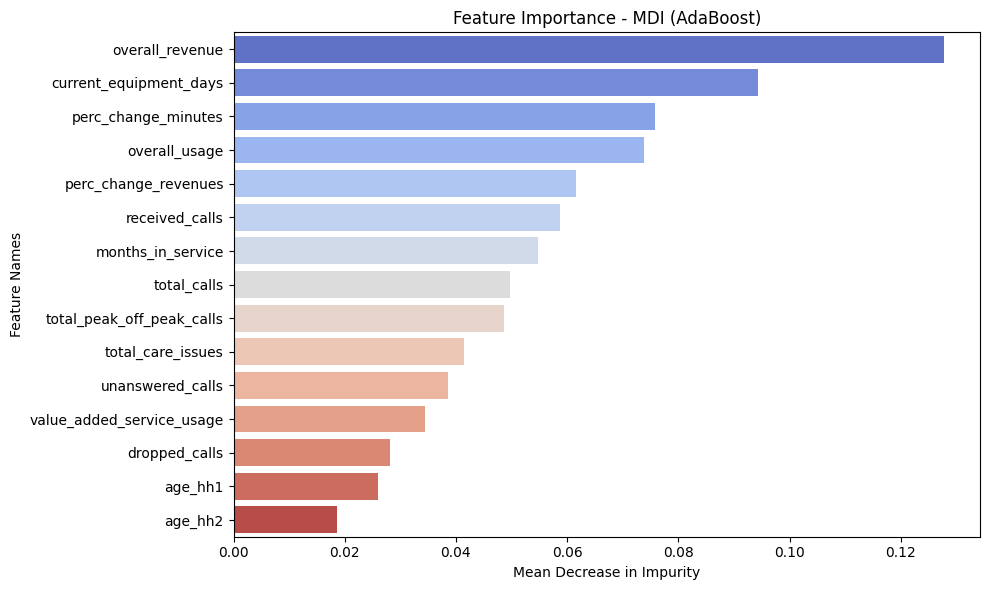

In [80]:
best_model = best_adaboost_model_tuned.estimator_

feature_importance = best_model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importance}
)

importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Feature Importance - MDI (AdaBoost)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

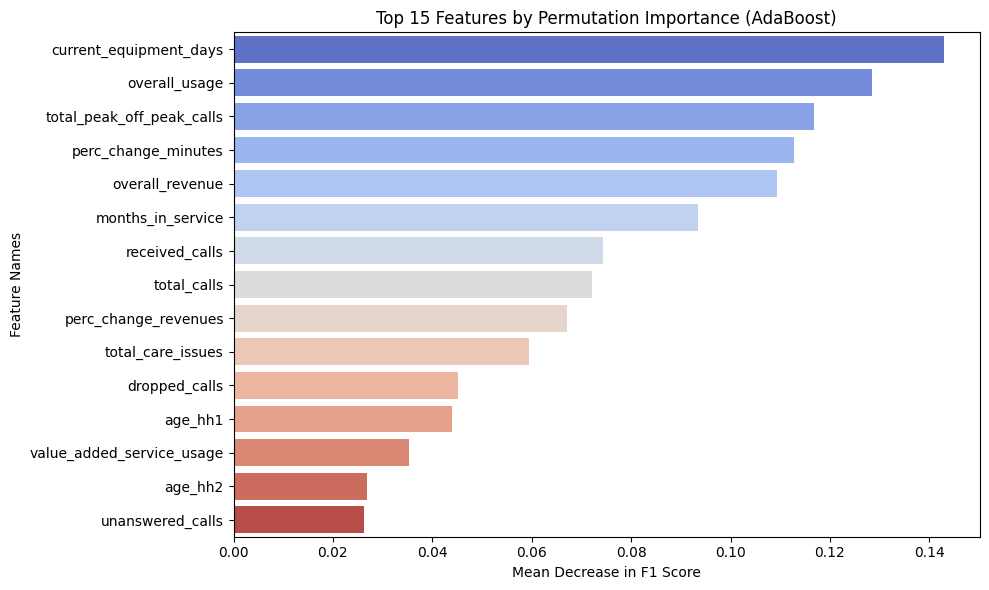

In [81]:
pi_results = permutation_importance(
    best_adaboost_model_tuned.estimator_,
    X_train,
    y_train,
    n_repeats=5,
    random_state=random_state,
    scoring="f1",
)

pi_data = {
    "Feature": X_train.columns,
    "Importance Mean": pi_results["importances_mean"],
    "Importance Std": pi_results["importances_std"],
}
pi_df = pd.DataFrame(pi_data)


pi_df_sorted = pi_df.sort_values("Importance Mean", ascending=False).reset_index(
    drop=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    x="Importance Mean", 
    y="Feature", 
    data=pi_df_sorted.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Top 15 Features by Permutation Importance (AdaBoost)")
plt.xlabel("Mean Decrease in F1 Score")
plt.ylabel("Feature Names")
plt.tight_layout()

### Gradient Boosting

For gradient boosting, we had a lot of trouble with run-time being an issue. After doing some research, we found a few papers on Histogram Based Gradient Boosting, which is much more efficient because it bins continuous variables allowing fewer splits to be checked. Empirical studies have shown that histogram based boosting performs just as well or better than traditional boosting (Guryanov, 2019). 

To ease the computational burden further, just like Adaboost we use the random search plus grid search approach in order to zoom in on areas in the hyperparameter space that are most promising.

Finally, we leverage a new feature in sklearn 1.5.0 which is native support for categorical variables. This means we don’t need to one-hot-encode things, giving the model fewer features to scan through, thus aiding in performance.


In [85]:
ohe_vars = [
    "prizm_code",
    "occupation",
    "marital_status"
]

cat_dict = dict(zip(ohe_vars, ["category"]*len(ohe_vars)))

# We leverage the native support of categorical variables in sklearn 1.5.0
#X_train_cat = pd.read_csv("./data/prod/X_train_cat.csv", dtype=cat_dict).drop("customer_id", axis=1)
X_train_cat = pd.read_csv("./data/prod/X_train_cat.csv", dtype=cat_dict)
y_train_cat = pd.read_csv("./data/prod/y_train_cat.csv", dtype=cat_dict)

#X_test_cat = pd.read_csv("./data/prod/X_test_cat.csv", dtype=cat_dict).drop("customer_id", axis=1)
X_test_cat = pd.read_csv("./data/prod/X_test_cat.csv", dtype=cat_dict)
y_test_cat = pd.read_csv("./data/prod/y_test_cat.csv", dtype=cat_dict)


non_categorical_vars = X_train_cat.select_dtypes(exclude=["object", "category"]).columns.tolist()
non_categorical_vars = list(non_categorical_vars)
categorical_mask = X_train_cat.dtypes.apply(lambda dtype: dtype.name == 'category')

#### Random Search

In [86]:
from sklearn.ensemble import HistGradientBoostingClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_categorical_vars)
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train_cat)
transformed_columns = preprocessor.get_feature_names_out()
categorical_mask = [col.split('__')[-1] in ohe_vars for col in transformed_columns]

In [87]:
xg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        early_stopping=True,
        tol=1e-04,
        n_iter_no_change=5,
        random_state=random_state,
        categorical_features=categorical_mask
    ))
])

param_grid = {
    'classifier__max_iter': np.arange(50, 800, 50),
    'classifier__learning_rate': np.logspace(-4, 0, 8),
    'classifier__max_leaf_nodes': np.arange(50, 800, 50),
    'classifier__l2_regularization': np.logspace(-4, 0, 8),
}

rsearch = RandomizedSearchCV(
    xg_pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1
).fit(X_train_cat, y_train_cat.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [88]:
top_5_results = rsearch.cv_results_['mean_test_score']
top_5_indices = np.argsort(top_5_results)[-5:][::-1]
top_5_params = rsearch.cv_results_['params']
top_5_scores = top_5_results[top_5_indices]

In [89]:
xg_top_5 = pd.DataFrame(top_5_params).iloc[top_5_indices]
xg_top_5['score'] = top_5_scores
xg_top_3 = xg_top_5.head(3)
xg_top_3

classifier__max_leaf_nodes  classifier__max_iter  \
28                         250                   350   
15                         250                   350   
29                          50                   650   

    classifier__learning_rate  classifier__l2_regularization     score  
28                        1.0                       0.000373  0.556357  
15                        1.0                       0.000100  0.555602  
29                        1.0                       0.268270  0.550919

#### Grid Search

In [90]:
restricted_leaf = np.arange(
    xg_top_3["classifier__max_leaf_nodes"].min(),
    xg_top_3["classifier__max_leaf_nodes"].max() + 1,
    50,
)

restricted_iter = np.arange(
    xg_top_3["classifier__max_iter"].min(),
    xg_top_3["classifier__max_iter"].max() + 1,
    50,
)

restricted_reg = np.arange(
    xg_top_3["classifier__l2_regularization"].min(),
    xg_top_3["classifier__l2_regularization"].max() + 1,
    0.1,
)

In [91]:
g_boost_param_grid = {
    'classifier__max_iter': restricted_iter,
    'classifier__learning_rate': [1],
    'classifier__max_leaf_nodes': restricted_leaf,
    'classifier__l2_regularization': [0.0001, 0.0003],
}

In [92]:
gsearch = GridSearchCV(
    xg_pipeline,
    param_grid=g_boost_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=1
).fit(X_train_cat, y_train_cat.values.ravel())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


In [93]:
gsearch.best_params_

{'classifier__l2_regularization': 0.0003,
 'classifier__learning_rate': 1,
 'classifier__max_iter': np.int64(350),
 'classifier__max_leaf_nodes': np.int64(150)}

#### Tune Threshold

In [94]:
categorical_mask = X_train_cat.dtypes.apply(lambda dtype: dtype.name == 'category')

In [95]:
best_xg_model = HistGradientBoostingClassifier(
    max_iter=gsearch.best_params_["classifier__max_iter"],
    learning_rate=1,
    max_leaf_nodes=gsearch.best_params_["classifier__max_leaf_nodes"],
    l2_regularization=gsearch.best_params_["classifier__l2_regularization"],
    early_stopping=True,
    tol=1e-04,
    n_iter_no_change=5,
    random_state=random_state,
    categorical_features=categorical_mask
)

In [96]:
best_xg_model_tuned = TunedThresholdClassifierCV(
    estimator = best_xg_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train_cat, y_train_cat.values.ravel())
print ("Optimal Threshold {:.4f}".format(best_xg_model_tuned.best_threshold_))

Optimal Threshold 0.4144


In [97]:
# classification report using train data
y_train_pred_xg = best_xg_model_tuned.predict(X_train_cat)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_xg, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85     19408
           1       0.62      0.53      0.57      7759

    accuracy                           0.77     27167
   macro avg       0.72      0.70      0.71     27167
weighted avg       0.77      0.77      0.77     27167



In [98]:
# classification report using test data
y_test_pred_xg = best_xg_model_tuned.predict(X_test_cat)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_xg, zero_division=0))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      4802
           1       0.40      0.34      0.36      1990

    accuracy                           0.66      6792
   macro avg       0.57      0.56      0.56      6792
weighted avg       0.64      0.66      0.65      6792



#### Feature Importance

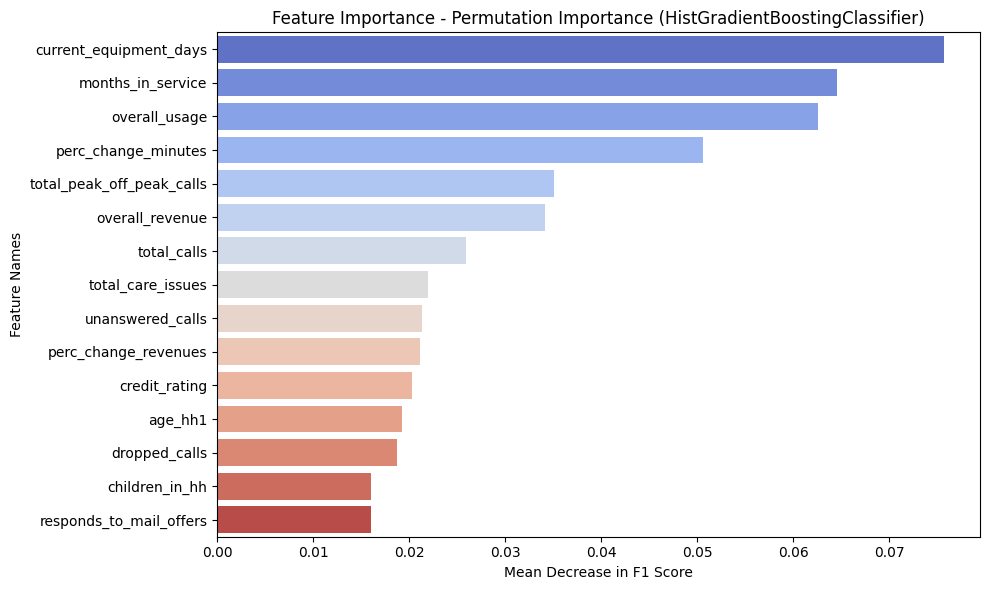

In [99]:
from sklearn.inspection import permutation_importance

best_model = best_xg_model_tuned.estimator_

# Permutation Importance (more robust)
result = permutation_importance(
    best_model, 
    X_train_cat, 
    y_train_cat.values.ravel(),
    n_repeats=5,
    random_state=random_state
)

# Create dataframe of permutation importances
importance_df = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Feature Importance - Permutation Importance (HistGradientBoostingClassifier)")
plt.xlabel("Mean Decrease in F1 Score")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

## Model Performance

**Model Performance:**

| Model               | Test Accuracy | Test F1 Score |
|---------------------|---------------|---------------|
| Baseline Logit      |          0.56 |          0.54 |
| Tuned Logit         |          0.62 |          0.57 |
| Tuned Random Forest |          0.64 |           **0.6** |
| Adaboost            |          **0.66** |          0.57 |
| Gradient Boosting   |          **0.66** |          0.56 |

In terms of accuracy Adaboost and Gradient Boosting are tied. As for f1-score the random forest model does the best. F1-score is slightly more reliable metric here due to imbalanced label data.

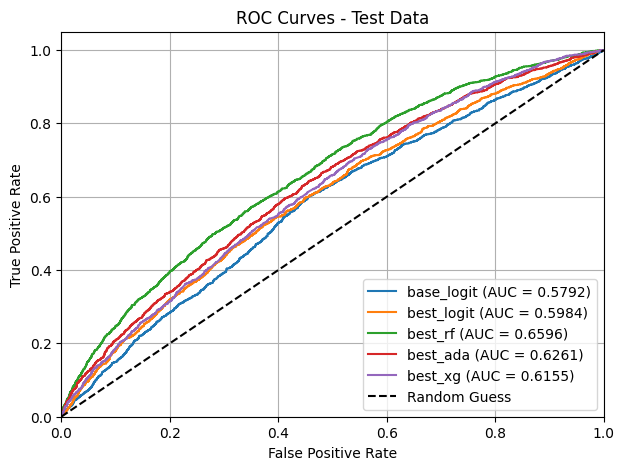

In [100]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
    'best_rf': rf_tuned.estimator_,
    'best_ada': best_adaboost_model_tuned.estimator_,
    'best_xg': best_xg_model_tuned.estimator_,
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
    'best_rf': X_test,
    'best_ada': X_test,
    'best_xg': X_test_cat,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
    'best_rf': y_test,
    'best_ada': y_test,
    'best_xg': y_test_cat,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

In terms of AUC, the best model is the random forest model with adaboost coming in second.

In [101]:
...

Ellipsis

## Causal Inference

In [53]:
# Let's find the binary feature that has largest discrepancy in churn rate

import numpy as np

def find_sorted_discrepancy_features(X_train, y_train):
    # Find binary features
    binomial_features = X_train.columns[X_train.nunique() == 2]
    
    discrepancies = []
    
    for feature in binomial_features:
        # Calculate churn rate discrepancy
        churn_rate_0 = y_train[X_train[feature] == 0].mean().values[0]
        churn_rate_1 = y_train[X_train[feature] == 1].mean().values[0]
    
        discrepancy = abs(churn_rate_1 - churn_rate_0)
        discrepancies.append((feature, discrepancy))

    sorted_discrepancies = sorted(discrepancies, key=lambda x: x[1], reverse=True)
    
    return sorted_discrepancies

# Let's see which features have large discrepancies
sorted_features = find_sorted_discrepancy_features(X_train, y_train)
print("Features sorted by churn rate discrepancy:")
for feature, discrepancy in sorted_features[:5]:
    print(f"Feature: {feature}, Discrepancy: {discrepancy:.4f}")

Features sorted by churn rate discrepancy:
Feature: made_call_to_retention_team, Discrepancy: 0.1532
Feature: retention_calls_is_zero, Discrepancy: 0.1532
Feature: retention_offers_accepted_is_zero, Discrepancy: 0.1230
Feature: handset_web_capable, Discrepancy: 0.1044
Feature: unanswered_calls_is_zero, Discrepancy: 0.0662


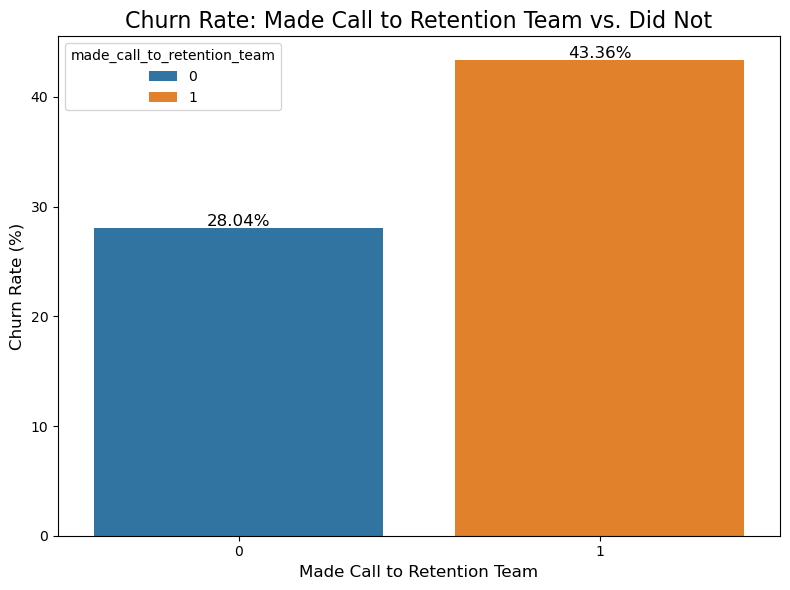

In [54]:
churn_rate_by_call = pd.concat([X_train['made_call_to_retention_team'], y_train], axis=1)
churn_rate_by_call.columns = ['made_call_to_retention_team', 'churn']  

grouped_data = churn_rate_by_call.groupby('made_call_to_retention_team')['churn'].mean().reset_index()
grouped_data['churn_rate'] = grouped_data['churn'] * 100  

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x='made_call_to_retention_team',
    y='churn_rate',
    data=grouped_data,
    ax=ax,
    hue='made_call_to_retention_team',
    palette=["#1f77b4", "#ff7f0e"]  # Set colors for the bars (blue for no churn, orange for churn)
)

ax.set_title('Churn Rate: Made Call to Retention Team vs. Did Not', fontsize=16)
ax.set_xlabel('Made Call to Retention Team', fontsize=12)
ax.set_ylabel('Churn Rate (%)', fontsize=12)

for p in ax.patches:
    if p.get_height() > 0: 
        ax.annotate(f'{p.get_height():.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Call to Retention Team

Does making a call to the retention team (made_call_to_retention_team) causally affect the churn rate, or is it merely correlated with it?

**Feature of my choice: made_call_to_retention_team**

Based on the binomial feature exploration, we find that the feature "made_call_to_retention_team" has the highest discrepancy in churn rate. Let's explore if this discrepancy implies casality. It’s important to investigate whether the act of calling the retention team leads to a increase in churn, or if other underlying factors (e.g., customer dissatisfaction, prior retention efforts) are influencing both the likelihood of calling and the likelihood of churn.

The findings from this causal analysis will guide our next steps, helping us decide whether to (1) retrain the retention team or (2) reward them for their performance.

In [56]:
# Target variable: 'made_call_to_retention_team'
y_train_ci_1 = X_train['made_call_to_retention_team']
X_train_ci_1 = X_train.drop(columns=['made_call_to_retention_team'])

# Lasso Like Logistic Regression
logit = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=5,
    penalty='l1',
    solver='saga',
    random_state=109,
    max_iter=1000,
    n_jobs=-1,
    scoring="accuracy"
)


logit.fit(X_train_ci_1, y_train_ci_1)

y_pred = logit.predict(X_train_ci_1)
accuracy = accuracy_score(y_train_ci_1, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")


/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSh

Train Accuracy: 0.9895


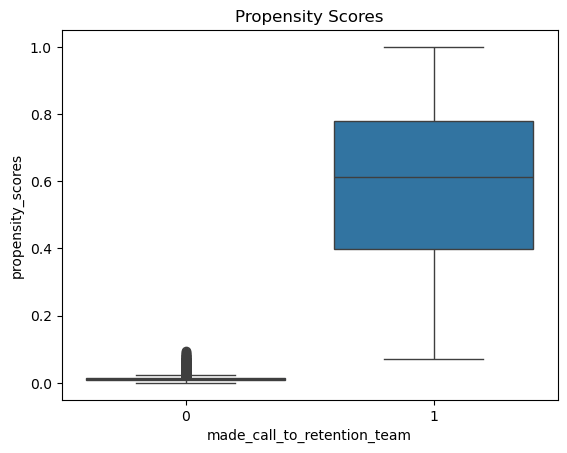

In [57]:
# Estimate propensity score
propensity_scores = logit.predict_proba(X_train_ci_1)[:, 1]
X = X_train_ci_1.copy()
X['propensity_scores'] = propensity_scores
X['made_call_to_retention_team'] = y_train_ci_1 

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores', x='made_call_to_retention_team', data=X)
ax.set_title("Propensity Scores")
plt.show()

In [63]:
# There are barely any overlap between the two group. Let's try adjusting for covariates using weights
# Calculate the weights for each unit based on propensity scores
treated_weight = 1 / propensity_scores
control_weight = 1 / (1 - propensity_scores)

# Combine weights with the data
weights = np.where(y_train_ci_1 == 1, treated_weight, control_weight)

# Rebalance the data by applying the weights
X_weighted = X_train_ci_1.copy()
X_weighted['weights'] = weights

logit.fit(X_weighted.drop(columns='weights'), y_train_ci_1, sample_weight=weights)

/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared/courseSh

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     random_state=109, scoring='accuracy', solver='saga')

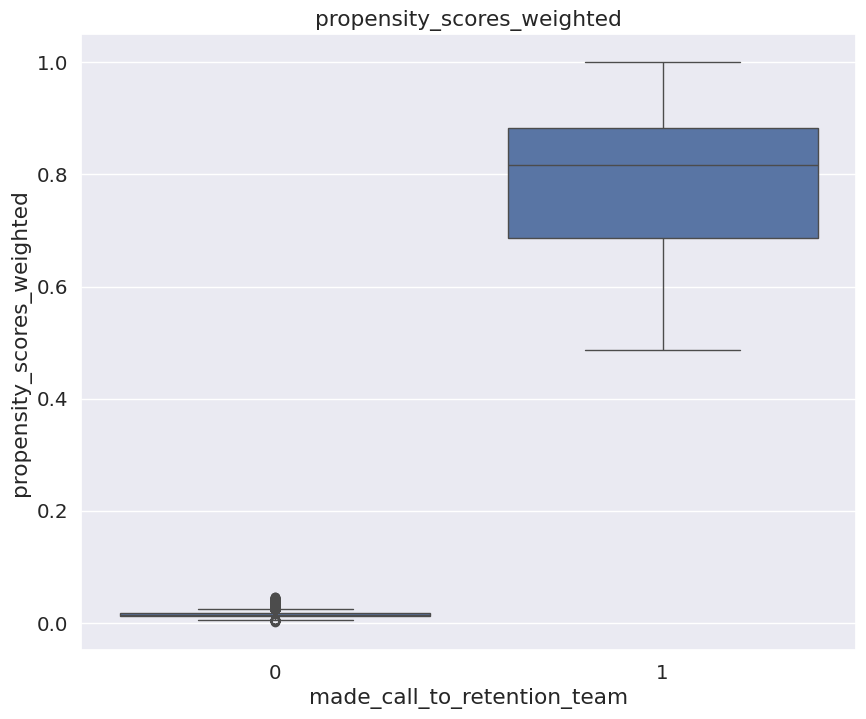

In [64]:
# Estimate propensity score
propensity_scores_weighted = logit.predict_proba(X_train_ci_1)[:, 1]
X['propensity_scores_weighted'] = propensity_scores_weighted

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores_weighted', x='made_call_to_retention_team', data=X)
ax.set_title("propensity_scores_weighted")
plt.show()

In [69]:
# It is still bad.. Time to explore simplier model to increase the overlap between the two groups!
# Rationale: simpler model with less model tuning will allow more users to "lookalike" to one another. Currently the model is overfitting too much

logit_simple = LogisticRegression()

logit_simple.fit(X_weighted.drop(columns='weights'), y_train_ci_1, sample_weight=weights)

/shared/courseSharedFolders/137799outer/137799/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

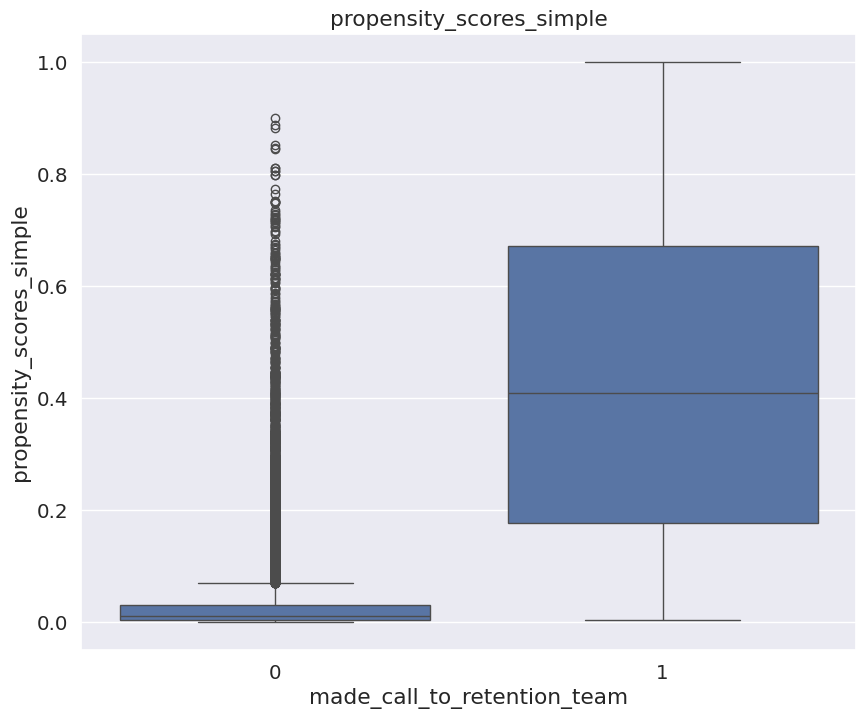

In [71]:
# Estimate propensity score
propensity_scores_simple = logit_simple.predict_proba(X_train_ci_1)[:, 1]
X['propensity_scores_simple'] = propensity_scores_simple

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores_simple', x='made_call_to_retention_team', data=X)
ax.set_title("propensity_scores_simple")
plt.show()

In [75]:
# although it is not perfect, it is much better. Let's use this 
X_train_df = pd.DataFrame(X)
X_train_df['id'] = range(0, X.shape[0])
X_train_df['made_call_to_retention_team'] = y_train_ci_1

In [76]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# Create a PsmPy object for propensity score matching
psm = PsmPy(X_train_df, treatment='made_call_to_retention_team', indx='id', exclude=[])

# Apply logistic propensity score matching
psm.logistic_ps(balance=False)

# Perform k-nearest neighbor matching using propensity scores
psm.knn_matched(matcher='propensity_scores_simple', replacement=True, caliper=None, drop_unmatched=True) 

# To get the means from the matched data:
matched_callers = psm.df_matched[psm.df_matched['made_call_to_retention_team'] == 1]['id'].values
matched_non_callers = psm.df_matched[psm.df_matched['made_call_to_retention_team'] == 0]['id'].values

# Calculate churn rates for both groups
callers_churn = y_train.iloc[matched_callers]  
non_callers_churn = y_train.iloc[matched_non_callers]  

callers_churn_rate = (callers_churn == 1).mean() 
non_callers_churn_rate = (non_callers_churn == 1).mean()  

# Print the results
print("Churn Rate (Callers):", callers_churn_rate)
print("Churn Rate (Non-Callers):", non_callers_churn_rate)
print("Adjusted Difference in Churn Rate:", callers_churn_rate - non_callers_churn_rate)

Churn Rate (Callers): churn    0.433557
dtype: float64
Churn Rate (Non-Callers): churn    0.25906
dtype: float64
Adjusted Difference in Churn Rate: churn    0.174497
dtype: float64


Overall, the findings highlight a potential relationship between retention team calls and increased chrun, but this cannot be definitvely attributed to cusation. The results may reflect other underlying factors, such as customer dissatisfaction, which is not in the current dataset, that drive both the likelihood of calling and churning. However, given the result of this causal inference analysis, we would recommend to re-train the customer retention call center team. 

Detail:
The analysis shows that customers who call the retention team have a higher churn rate (43.66%) compared to non-callers (25.91%). This usggests a strong association between calling the retention team and churn, even after adjusting for confounders using propensity socre matching. However, the propensity score distribution indicate poor overlap between groups, limiting the comparability and reliability of the casual estimate. While the use of simpler models improved balance, residual bias and unobserved counfounders may still influence the results. 

Steps to improve the overlap of propensity score between the treatment (callers) and control (non callers) groups:
1. Initial propensity score estimation:
- Trained a lasso like logistic regression model to estimate propensity score
 - Visualized the propensity score distributions using a boxplot, which revealed poor overlap between the two groups.

2. Rebalancing Using Inverse Probability of Treatment Weighting (IPTW):
- Calculated inverse probability weights for both treated and control groups:
    - Treated group: Weight = $\frac{1}{\text{Propensity Score}} $
    - Control group: Weight = $\frac{1}{1 - \text{Propensity Score}} $
- Applied these weights during logistic regression to adjust for covariates, rebalancing the data.

3. Simpler Propensity Score Model:
- Recognized that the initial model overfit to the data and switched to a simpler logistic regression model with no regularization.
- This simpler model improved overlap between the propensity score distributions of the two groups, though residual imbalance remained.

#### Responding to Mail Offers 

Does responding to mail offers causally affect churn, or is it just correlated?

**Feature of my choice: responds_to_mail_offers**

Based on the model exploration, responds_to_mail_offers is one of the only binary variables that were identified as important features to predict churn. Let’s investigate whether responding to mail offers directly reduces churn or if other underlying factors drive both service usage and churn.

The findings from this causal analysis will guide our next steps, helping us decide whether to (1) invest further in mail offers or (2) Maintain the status quo if they have no causal impact on churn rates.

In [87]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # let's remove the warning for now

# Target variable: 'responds_to_mail_offers'
y_train_ci_2 = X_train['responds_to_mail_offers']
X_train_ci_2 = X_train.drop(columns=['responds_to_mail_offers'])

# Lasso Like Logistic Regression
logit = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=5,
    penalty='l1',
    solver='saga',
    random_state=109,
    max_iter=1000,
    n_jobs=-1,
    scoring="accuracy"
)

logit.fit(X_train_ci_2, y_train_ci_2)

y_pred = logit.predict(X_train_ci_2)
accuracy = accuracy_score(y_train_ci_2, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.9835


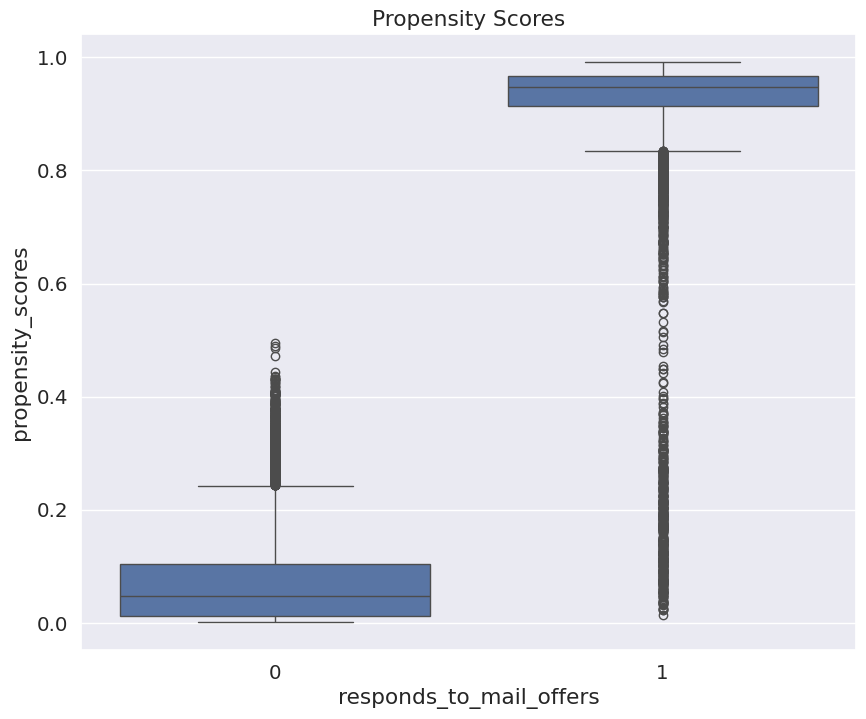

In [88]:
# Estimate propensity score
propensity_scores = logit.predict_proba(X_train_ci_2)[:, 1]
X = X_train_ci_2.copy()
X['propensity_scores'] = propensity_scores
X['responds_to_mail_offers'] = y_train_ci_2 

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores', x='responds_to_mail_offers', data=X)
ax.set_title("Propensity Scores")
plt.show()

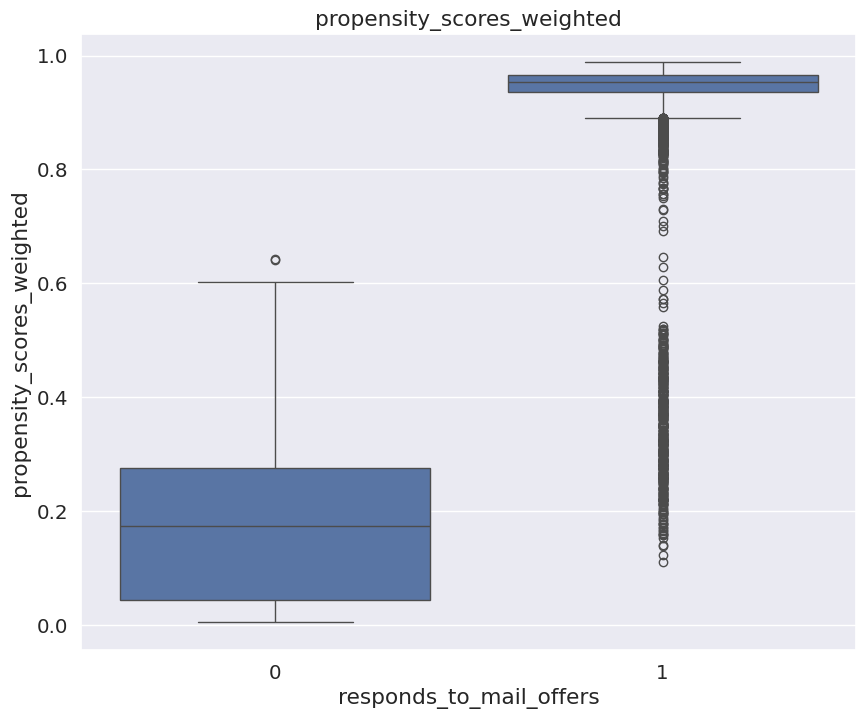

In [89]:
# Calculate the weights for each unit based on propensity scores
treated_weight = 1 / propensity_scores
control_weight = 1 / (1 - propensity_scores)

# Combine weights with the data
weights = np.where(y_train_ci_2 == 1, treated_weight, control_weight)

# Rebalance the data by applying the weights
X_weighted = X_train_ci_2.copy()
X_weighted['weights'] = weights

logit.fit(X_weighted.drop(columns='weights'), y_train_ci_2, sample_weight=weights)

# Estimate propensity score
propensity_scores_weighted = logit.predict_proba(X_train_ci_2)[:, 1]
X['propensity_scores_weighted'] = propensity_scores_weighted

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores_weighted', x='responds_to_mail_offers', data=X)
ax.set_title("propensity_scores_weighted")
plt.show()

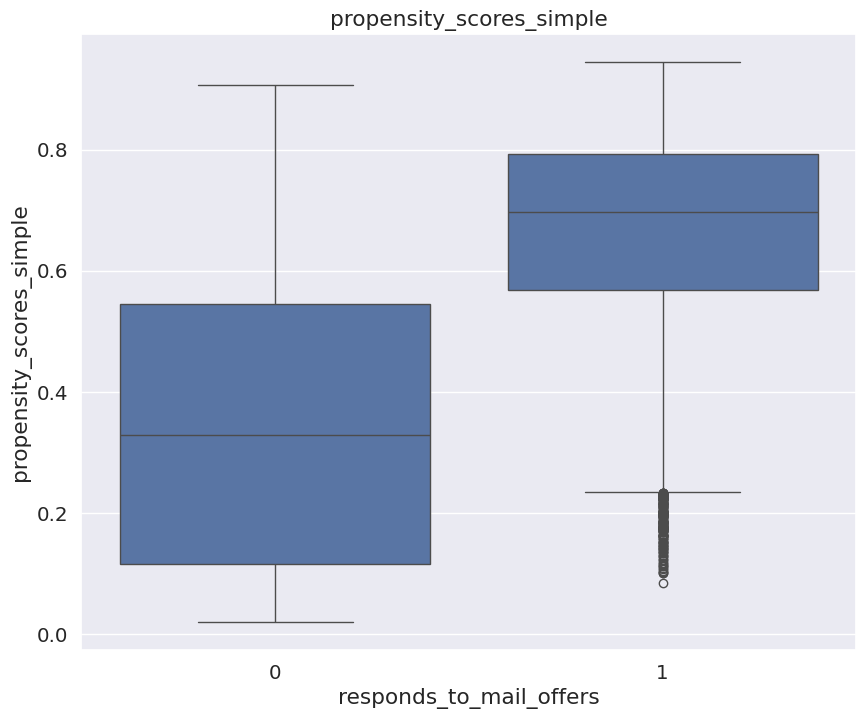

In [90]:
# Simpler model to increase overlap between groups
logit_simple = LogisticRegression()

logit_simple.fit(X_weighted.drop(columns='weights'), y_train_ci_2, sample_weight=weights)

# Estimate propensity score
propensity_scores_simple = logit_simple.predict_proba(X_train_ci_2)[:, 1]
X['propensity_scores_simple'] = propensity_scores_simple

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores_simple', x='responds_to_mail_offers', data=X)
ax.set_title("propensity_scores_simple")
plt.show()

In [91]:
# Use this improved overlap for further steps
X_train_df = pd.DataFrame(X)
X_train_df['id'] = range(0, X.shape[0])
X_train_df['responds_to_mail_offers'] = y_train_ci_2

# Create a PsmPy object for propensity score matching
psm = PsmPy(X_train_df, treatment='responds_to_mail_offers', indx='id', exclude=[])

# Apply logistic propensity score matching
psm.logistic_ps(balance=False)

# Perform k-nearest neighbor matching using propensity scores
psm.knn_matched(matcher='propensity_scores_simple', replacement=True, caliper=None, drop_unmatched=True) 

# To get the means from the matched data:
matched_responders = psm.df_matched[psm.df_matched['responds_to_mail_offers'] == 1]['id'].values
matched_non_responders = psm.df_matched[psm.df_matched['responds_to_mail_offers'] == 0]['id'].values

# Calculate churn rates for both groups
responders_churn = y_train.iloc[matched_responders]  
non_responders_churn = y_train.iloc[matched_non_responders]  

responders_churn_rate = (responders_churn == 1).mean() 
non_responders_churn_rate = (non_responders_churn == 1).mean()  

# Print the results
print("Churn Rate (Responders):", responders_churn_rate)
print("Churn Rate (Non-Responders):", non_responders_churn_rate)
print("Adjusted Difference in Churn Rate:", responders_churn_rate - non_responders_churn_rate)

Churn Rate (Responders): churn    0.268234
dtype: float64
Churn Rate (Non-Responders): churn    0.27764
dtype: float64
Adjusted Difference in Churn Rate: churn   -0.009406
dtype: float64


The analysis indicates that customers who respond to mail offers have a slightly lower churn rate (26.82%) compared to non-responders (27.76%). While this suggests a small association between responding to mail offers and reduced churn, the difference is minimal and may not be statistically significant. Propensity score matching was used to adjust for observable covariates, and the propensity score distributions after adjustment indicate moderate overlap between the two groups.

These findings suggest that responding to mail offers does not have a clear causal impact on churn rates. The small difference in churn rates may be driven by underlying factors that influence both mail offer response behavior and churn (e.g., customer engagement levels). Given the limited causal effect, further investments in mail offers might not yield significant improvements in churn reduction. 

## Future Work

In this project, we have explored various models to predict customer churn and conducted causal inference analysis to investigate the impact of specific features on churn rates. The results of the models are decent but they still struggle to find a strong relationship between the features and churn. This is a result of the underlying data is noisy, making it difficult for a model to identify a clear relationship. The data itself is from a call center which doesn't have the reputation of being the most stringent with data quality controls. Therefore the results may be reflective of the underlying data quality issues.

The best performing model was the Random Forest model. By following the procedure layed out in Breiman's Random Forest paper, we were able to achieve an F1 score of 0.6. However, the model still struggled to find a strong relationship between these features and churn. This suggests that there may be other factors at play that are influencing churn rates.

In addition to the predictive models, we have also conducted causal inference analysis to investigate the impact of specific features on churn rates. Unfortunately, the propensity scores had no overlap which made inference nearly impossible.

For future work, we recommend the following steps to improve the predictive performance and causal inference analysis:

1. **Fix Data Quality Issues**: If possible, address the data quality issues by requesting a new set of data from the call center. This will make the biggest difference, more than any model tuning or feature engineering.
2. **Feature Engineering**: Create new features that may better capture the underlying patterns in the data. Nonlinear and interaction terms were not explored in this project due to computational limitations but there may be a signal in these features.
3. **Advanced Models**: Explore more advanced models ensemble methods like mixture of experts or model stacking. There is the possibility that one can find a combination of models where each focuses on a different part of the feature space.

Thank you for reading our report. We hope you found it informative and insightful. Our emails are listed in the appendix if you have any questions or would like to discuss further.

## Acknowledgements

The authors would like to thank Li Yao for his guidance, support and helpful feedback throughout the project. We would also like to thank the teaching staff for teaching us and providing us with the knowledge to succeed.  

## Sources

Abdulkadir, R. (2022). Customer Churn Prediction on the Cell2Cell Dataset by Deep Learning. Tilburg University - Department of Cognitive Science & Artificial Intelligence. http://arno.uvt.nl/show.cgi?fid=160769

Bengio, Y., & Grandvalet, Y. (2004). No Unbiased Estimator of the Variance of K-Fold Cross-Validation. Journal of Machine Learning Research, 5. https://www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf


Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32. https://doi.org/10.1023/a:1010933404324


Guryanov, A. (2019). Histogram-Based algorithm for building gradient boosting ensembles of piecewise linear decision trees. In Lecture notes in computer science (pp. 39–50). https://doi.org/10.1007/978-3-030-37334-4_4


Kohavi, R. (n.d.). A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. Stanford Robotics Journal. https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf


Ling, C. X., Huang, J., & Zhang, H. (2003). AUC: A Better Measure than Accuracy in Comparing Learning Algorithms. In Lecture notes in computer science (pp. 329–341). https://doi.org/10.1007/3-540-44886-1_25


## Appendix

### Theorem 1.2. <a class="anchor" id="theorem-1-2"></a>

(Adapted)For a random forest classifier using majority vote as a prediction, as the number of trees increases, for almost surely all sequences $\Theta_1$,...,$\Theta_n$, the $PE^*$ converges to 

$$
P_{\bold{X}, y}(P_{\Theta}(h(\bold{X}, \Theta) = y) - max_{j\neq y}P_{\Theta}(h(\bold{X}, \Theta) = j)  < 0)
$$

- Here $X$ is the feature matrix and $y$ is the vector of true labels. 
- $\Theta$ denotes the randomness in a Random Forest model. Note that random forest has two sources of randomness, bootstrapping and feature selection.
- $h(\bold{X}, \Theta)$ is the prediction of the Random Forest model.
- $PE^*$ is the OOB error rate.

Here the author defines margin as difference between the probability that a randomly chosen tree predicts the correct class subtracted by the maximum probability that a randomly chosen tree predicts the wrong class. 

$$
P_{\Theta}(h(\bold{X}, \Theta) = y) - max_{j\neq y}P_{\Theta}(h(\bold{X}, \Theta)
$$

As the number of trees increases, the probability of error on the test set converges to the probability that this margin is negative. The implication is that the test error of a Random Forest model plateaus as the number of trees increases.

### Definition 1. Mean Decrease in Impurity  <a class="anchor" id="def-mdi"></a>

For a given split that uses feature $q$, without loss of generality in the criteria, let the decrease in impurity be defined as 
$$
\Delta I_q = \frac{n}{N} \bigg[Gini_n - \sum_{m \in Child(n)} \frac{m}{n} Gini_m \bigg].
$$

For a single tree, the MDI of a given feature $q$ is defined as
$$
MDI_q = \sum_{\text{splits using q}} \Delta I_q.
$$

Normalizing by dividing total of feature importances yields 

$$
MDI_q' = \frac{MDI_q}{\sum_q^Q MDI_q}
$$

, for all features in $q \in Q$.

Calculating the mean MDI across all trees in the forest gives the final MDI for a given feature $q$:
$$
MDI'_{q, forest} = \frac{1}{T} \sum_{t=1}^T MDI'_{q,t}
$$

### Lemma 1: Optimal Adaboost Lambda  <a class="anchor" id="lemma-1"></a>

The optimal $\lambda$ for Adaboost is given by $\lambda = \frac{1}{2} \log \bigg( \frac{1 - \epsilon}{\epsilon} \bigg)$, where $\epsilon$ is the error rate of the weak learner. 

<u>Proof:</u>

The proof is straightforward. We have to just take the derivative of the exponential loss function with respect to $\lambda$ and set it equal to zero.

$$
\frac{\partial}{\partial \lambda} \frac{1}{N} \sum_{n=1}^N \exp \bigg( -y_n (T + \lambda^{(i)}S^{(i)}(X_n)) \bigg)
$$

$$
= \sum_{n=1}^N exp(-y_nT) \exp(-y_n\lambda^{(i)}S^{(i)}(X_n))
$$

Split the sum into correct and incorrect cases.

$$
= \sum_{correct} e^{-y_nT}e^{-\lambda^{(i)}} + \sum_{incorrect}  e^{-y_nT} e^{\lambda^{(i)}} 
$$

We've done only manipulation so far. Now we apply the definition of weights, differentiate and set to 0. For $n > 1$ the weights are $e^{-y_nT}$.

$$
= \sum_{incorrect} w_n e^{\lambda^{(i)}} - \sum_{correct} w_ne^{-\lambda^{(i)}}
$$

We can express the weights in terms of errors. For correct classifications it is $1-\epsilon$ and for incorrect it is $\epsilon$, so then setting the quantity to zero we get

$$
= e^{\lambda^{(i)}}(\epsilon) - e^{-\lambda^{(i)}}(1 - \epsilon) = 0
$$

Solving for $\lambda$ we get

$$
\frac{e^{\lambda^{(i)}}}{e^{\lambda^{(i)}}} = \frac{1 - \epsilon}{\epsilon}
$$

$$
e^{2\lambda^{(i)}} = \frac{1 - \epsilon}{\epsilon} \rightarrow \lambda^{(i)} = \frac{1}{2} \ln \bigg( \frac{1 - \epsilon}{\epsilon} \bigg)
$$

### Lemma 2: Boostrapping Proportion

For a Random Forest model, the proportion of data not used to train a given tree is $\frac{1}{e}$. 

For a given an inital sample of size $n$, any boostrap sample generated from this sample will also be size $n$. The probability that a given observation is selected at a given draw is then $P(\text{selected}) = \frac{1}{n}$. Taking the logical converse we get the probability of note being selected a given draw as $P(\text{not selected}) = 1 - \frac{1}{n}$. Since boostrapping is done with replacement, the probability of never being selected for the bootstrap sample is then

$$
P(\text{not selected})^n = \bigg(1 - \frac{1}{n}\bigg)^n
$$

Taking the limit as $n \to \infty$ we get

$$
\lim_{n \to \infty} \bigg(1 - \frac{1}{n}\bigg)^n = \frac{1}{e} \approx 0.368
$$

### Lemma 3: Variance of Bagged Trees <a class="anchor" id="lemma-3"></a>

Let $X = \sum_{i=1}^B T_i$ where $B$ is the number of trees and $T_i$ is the individual tree. Using the definition of variance, the variance of $X$ is then

$$
Var(X) = \bold{E}\bigg[(\frac{1}{B} \sum_{i=1}^B X_i - \mu)^2 \bigg]
$$

We factor out the constant and square it using properties of variance to get

$$
= \bigg(\frac{1}{B}\bigg)^2 \bold{E}\bigg[(\sum_{i=1}^B X_i - \mu)^2 \bigg]
$$

Since trees can be correlated we expand the square to get

$$
= \frac{1}{B^2} \bold{E}\bigg[\sum_{i=1}^B (X_i - \mu)(X_j - \mu) \bigg]
$$

The term inside the expectation is just the covariance of $X_i$ and $X_j$. There are now two cases to consider 1) the diagonal elements of the covariance matrix, which means $i=j$ and 2) the off diagonals elements where $i \neq j$. The diagonal elements are just the variance of a single tree, which is $\sigma^2$. The off diagonal elements are the covariance of two trees, which is $\rho \sigma^2$. There are $B$ diagonal elements and $B(B-1)$ off diagonal elements. Plugging this back into the equation we get

$$
= \frac{1}{B^2} (B^2 - B)\rho\sigma^2 + B\sigma^2 = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
$$

Notice that with decision trees the $\rho$ term is high because randomization only occurs at the sampling step and decision trees are prone to using the same strong predictor at the top of the tree. Contrast this with random forests where the $\rho$ term is low because the trees are uncorrelated because randomization happens at sampling and splitting (building the tree). This is how random forests is able to reduce variance. 

### Lemma 4: Averaging Reduces Variance <a class="anchor" id="lemma-4"></a>

The variance of an average is given by $\frac{\sigma^2}{B}$ where $\sigma^2$ is the variance of a single tree and $B$ is the number of trees. The variance of a single prediction on the other hand is given by $\sigma^2$. 

$$
Var(\bar{X}) = \frac{\sigma^2}{B} < \sigma^2 ~~~ \forall B > 1
$$